https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap


https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://link.springer.com/article/10.1007/s13748-016-0094-0

https://stackoverflow.com/questions/62663370/using-pipeline-with-gridsearchcv
https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import datetime
import time
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from numpy import mean, std
from sklearn.model_selection import cross_val_predict

In [3]:
def ColMode(df, feature, key):
    
    feature = [feature]
    
    # dataframe de travail sans les nans et avec les colonnes feature et key
    cols = feature.copy()
    cols.extend(key)
    tmp = df[cols].dropna()
    
    # Count par feature-key
    tmp = pd.DataFrame(tmp.groupby(cols).size(), columns=['COUNT']).reset_index(drop=False)
    
    # Par key, valeurs les plus fréquentes de la feature
    tmpMaxCount = tmp.groupby(by=key).agg({'COUNT': 'max'}).reset_index(drop=False)
    colsMerge = key.copy()
    colsMerge.append('COUNT')
    tmp = tmp.merge(tmpMaxCount, left_on=colsMerge, right_on=colsMerge)

    # A chaque valeur de feature ont affecte un poids égal au nombre de fois que la valeur est prise dans la table
    colsPopularity = feature.copy()
    colsPopularity.append('COUNT')
    popularity = tmp.groupby(feature).agg({'COUNT': 'sum'}).reset_index(drop=False)
    colsPopularity = feature.copy()
    colsPopularity.append('POPULARITY')
    popularity.columns = colsPopularity
    
    tmp = tmp.merge(popularity)
    
    tmp2 = tmp.groupby(key).agg({'COUNT': 'max'}).reset_index(drop=False)
    tmp = tmp.merge(tmp2)
    tmp2 = tmp.groupby(key).agg({'POPULARITY': 'min'}).reset_index(drop=False)
    tmp = tmp.merge(tmp2)
    
    del tmp['COUNT']
    del tmp['POPULARITY']
    
    return tmp

def TransformUnique(df, key):
    categorical_ix = df.select_dtypes(include=['object']).columns
    dfCat = df[key].drop_duplicates()
    for col in categorical_ix:
        dfCat = dfCat.merge(ColMode(df, col, key), left_on=key, right_on=key, how='left')
    dfNum = df.groupby(key).mean().reset_index(drop=False)
    dfUnique = dfCat.merge(dfNum, left_on=key, right_on=key, how='left')
    return dfUnique

### Fonction de mise à plat des fichiers

In [4]:

def flat_df(defaultData=False, splitRate=0):
    
    t1 = time.time()
    
    print(datetime.datetime.now())
    
    #########################################
    # CHARGEMENT DES FICHIERS
    #########################################
    
    dfApplicationTrain = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
    dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
    dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
    dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
    dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
    dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
    dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
    
    t2 = time.time()
    print("{} - {} - fichiers chargés".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    
    #########################################
    # REDUCTION DU JEU DE DONNEES (ce n'est pas le train/test split classique)
    #########################################
    
    if splitRate == 0:
        dfApplication = dfApplicationTrain
    else:
        dfApplication, _ = train_test_split(dfApplicationTrain, test_size=splitRate, random_state=1)

    dfPreviousApplication = dfPreviousApplication.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
    dfPosCashBalance = dfPosCashBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfInstallmentsPayments = dfInstallmentsPayments.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfCreditCardBalance = dfCreditCardBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfBureau = dfBureau.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
    dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')
    
    t2 = time.time()
    print("{} - {} - réduction du jeu de données".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    
    #########################################
    # MARQUAGE DES VALEURS MANQUANTES
    #########################################

    dfApplication = dfApplication.replace('XNA', np.nan)
    dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
    dfBureau = dfBureau.replace('XNA', np.nan)
    dfApplication = dfApplication.replace('XAP', np.nan)
    dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
    dfBureau = dfBureau.replace('XAP', np.nan)
    dfBureauBalance = dfBureauBalance.replace('X', np.nan)
    
    t2 = time.time()
    print("{} - {} - marquage des valeurs manquantes".format(datetime.datetime.now(), t2-t1))
    t1 = t2



    #########################################
    # SUPPRESSION DE LIGNES
    #########################################

    if not defaultData:
        dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]
        dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]
        dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]
        
        
        t2 = time.time()
        print("{} - {} - suppression de lignes".format(datetime.datetime.now(), t2-t1))
        t1 = t2


    #########################################
    # SUPPRESSION DE VARIABLES
    #########################################

    if not defaultData:

        # COLONNES NON PERTINENTES

        # Suppression de champs non pertinents
        col_to_del = [
        'FLAG_MOBIL', # Did client provide mobile phone
        'FLAG_EMP_PHONE', # Did client provide work phone (1=YES, 0=NO)
        'FLAG_WORK_PHONE', # Did client provide home phone (1=YES, 0=NO)
        'FLAG_CONT_MOBILE', # Was mobile phone reachable (1=YES, 0=NO)
        'FLAG_PHONE', # Did client provide home phone (1=YES, 0=NO)
        'FLAG_EMAIL', # Did client provide email (1=YES, 0=NO)

        # ininéressant
        'NAME_TYPE_SUITE',  # Who was accompanying client when he was applying for the loan
        'DAYS_ID_PUBLISH', # How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
        'DAYS_REGISTRATION', # How many days before the application did client change his registration,time only relative to the application
        'WEEKDAY_APPR_PROCESS_START', # On which day of the week did the client apply for the loan
        'HOUR_APPR_PROCESS_START', # Approximately at what hour did the client apply for the loan,rounded
        'DAYS_LAST_PHONE_CHANGE', # How many days before application did client change phone

        # flags de comparaison de donnée
        'REG_REGION_NOT_LIVE_REGION', # Flag if client's permanent address does not match contact address
        'REG_REGION_NOT_WORK_REGION', # Flag if client's permanent address does not match contact address
        'LIVE_REGION_NOT_WORK_REGION', # Flag if client's contact address does not match work address
        'REG_CITY_NOT_LIVE_CITY', # Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
        'REG_CITY_NOT_WORK_CITY', # Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
        'LIVE_CITY_NOT_WORK_CITY', # Flag if client's contact address does not match work address (1=different, 0=same, at city level)

        ]

        for col in col_to_del:
            del dfApplication[col]

        for col in dfApplication:
            if col[0:13] == 'FLAG_DOCUMENT':  # Did client provide document
                del dfApplication[col]



        del dfPreviousApplication['FLAG_LAST_APPL_PER_CONTRACT'] # Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
        del dfPreviousApplication['NFLAG_LAST_APPL_IN_DAY'] # Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice

        del dfPreviousApplication['NAME_TYPE_SUITE'] # Who accompanied client when applying for the previous application
        del dfPreviousApplication['WEEKDAY_APPR_PROCESS_START'] #On which day of the week did the client apply for the loan
        del dfPreviousApplication['HOUR_APPR_PROCESS_START'] #Approximately at what hour did the client apply for the loan
        del dfPreviousApplication['NAME_CLIENT_TYPE'] #Was the client old or new client when applying for the previous application
        del dfPreviousApplication['SELLERPLACE_AREA'] #Selling area of seller place of the previous application


        del dfInstallmentsPayments['NUM_INSTALMENT_VERSION'] #Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
        del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER'] #On which installment we observe payment

        del dfPosCashBalance['CNT_INSTALMENT'] # Term of previous credit (can change over time)
        del dfPosCashBalance['CNT_INSTALMENT_FUTURE'] # Installments left to pay on the previous credit


        # COLONNES AVEC TROP DE VALEURS MANQUANTES

        del dfPreviousApplication['RATE_INTEREST_PRIMARY']
        del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
        del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']
        del dfBureau['AMT_ANNUITY']


        # COLONNES AVEC TROP DE VALEURS IDENTIQUES

        del dfPreviousApplication['NAME_PAYMENT_TYPE']
        del dfBureau['CREDIT_CURRENCY']
        del dfBureau['CNT_CREDIT_PROLONG']
        del dfBureau['CREDIT_DAY_OVERDUE']
        del dfBureau['AMT_CREDIT_SUM_OVERDUE']


        # COLONNES CORRELLEE AVEC UNE AUTRE

        del dfApplication['EXT_SOURCE_1']
        del dfApplication['OBS_60_CNT_SOCIAL_CIRCLE']
        del dfApplication['DEF_60_CNT_SOCIAL_CIRCLE']
        del dfApplication['OWN_CAR_AGE']
        del dfApplication['CNT_FAM_MEMBERS']
        del dfApplication['AMT_GOODS_PRICE']
        del dfApplication['REGION_RATING_CLIENT_W_CITY']
        del dfApplication['REGION_POPULATION_RELATIVE']
        del dfApplication['APARTMENTS_AVG']
        del dfApplication['APARTMENTS_MEDI']
        del dfApplication['BASEMENTAREA_AVG']
        del dfApplication['BASEMENTAREA_MEDI']
        del dfApplication['COMMONAREA_AVG']
        del dfApplication['COMMONAREA_MEDI']
        del dfApplication['ELEVATORS_AVG']
        del dfApplication['ELEVATORS_MEDI']
        del dfApplication['ENTRANCES_AVG']
        del dfApplication['ENTRANCES_MEDI']
        del dfApplication['FLOORSMAX_AVG']
        del dfApplication['FLOORSMAX_MEDI']
        del dfApplication['FLOORSMIN_AVG']
        del dfApplication['FLOORSMIN_MEDI']
        del dfApplication['LANDAREA_AVG']
        del dfApplication['LANDAREA_MEDI']
        del dfApplication['LIVINGAPARTMENTS_AVG']
        del dfApplication['LIVINGAPARTMENTS_MEDI']
        del dfApplication['LIVINGAREA_AVG']
        del dfApplication['LIVINGAREA_MEDI']
        del dfApplication['NONLIVINGAPARTMENTS_AVG']
        del dfApplication['NONLIVINGAPARTMENTS_MEDI']
        del dfApplication['NONLIVINGAREA_AVG']
        del dfApplication['NONLIVINGAREA_MEDI']
        del dfApplication['YEARS_BEGINEXPLUATATION_AVG']
        del dfApplication['YEARS_BEGINEXPLUATATION_MEDI']
        del dfApplication['YEARS_BUILD_AVG']
        del dfApplication['YEARS_BUILD_MEDI']
        del dfApplication['EMERGENCYSTATE_MODE']
        del dfApplication['HOUSETYPE_MODE']
        del dfApplication['NONLIVINGAREA_MODE']
        del dfApplication['NONLIVINGAPARTMENTS_MODE']
        del dfApplication['BASEMENTAREA_MODE']
        del dfApplication['COMMONAREA_MODE']
        del dfApplication['ELEVATORS_MODE']
        del dfApplication['ENTRANCES_MODE']
        del dfApplication['FLOORSMAX_MODE']
        del dfApplication['FLOORSMIN_MODE']
        del dfApplication['LANDAREA_MODE']
        del dfApplication['LIVINGAPARTMENTS_MODE']
        del dfApplication['LIVINGAREA_MODE']
        del dfApplication['TOTALAREA_MODE']
        del dfApplication['YEARS_BUILD_MODE']
        del dfApplication['FONDKAPREMONT_MODE']


        del dfPreviousApplication['DAYS_FIRST_DRAWING']
        del dfPreviousApplication['DAYS_FIRST_DUE']
        del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
        del dfPreviousApplication['DAYS_LAST_DUE']
        del dfPreviousApplication['DAYS_TERMINATION']
        del dfPreviousApplication['AMT_APPLICATION']
        del dfPreviousApplication['AMT_GOODS_PRICE']
        del dfPreviousApplication['AMT_ANNUITY']
        del dfPreviousApplication['CNT_PAYMENT']
        del dfPreviousApplication['NAME_PORTFOLIO']
        del dfPreviousApplication['CODE_REJECT_REASON']
        del dfPreviousApplication['CHANNEL_TYPE']
        del dfPreviousApplication['NAME_CONTRACT_TYPE']
        del dfPreviousApplication['PRODUCT_COMBINATION']
        del dfPreviousApplication['NAME_GOODS_CATEGORY']
        del dfPreviousApplication['AMT_DOWN_PAYMENT']


        del dfCreditCardBalance['AMT_INST_MIN_REGULARITY']
        del dfCreditCardBalance['AMT_RECEIVABLE_PRINCIPAL']
        del dfCreditCardBalance['AMT_RECIVABLE']
        del dfCreditCardBalance['AMT_TOTAL_RECEIVABLE']
        del dfCreditCardBalance['AMT_DRAWINGS_POS_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_ATM_CURRENT']
        del dfCreditCardBalance['AMT_PAYMENT_CURRENT']
        del dfCreditCardBalance['AMT_CREDIT_LIMIT_ACTUAL']
        del dfCreditCardBalance['CNT_DRAWINGS_ATM_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_POS_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_OTHER_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_CURRENT']

        del dfPosCashBalance['SK_DPD_DEF']

        del dfBureau['DAYS_CREDIT_UPDATE']
        del dfBureau['DAYS_ENDDATE_FACT']
        del dfBureau['AMT_CREDIT_SUM_DEBT']


        # COLONNES DE TABLE DU TROISIEME NIVEAU

        del dfCreditCardBalance['AMT_BALANCE']
        del dfCreditCardBalance['AMT_PAYMENT_TOTAL_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_OTHER_CURRENT']
        del dfCreditCardBalance['CNT_INSTALMENT_MATURE_CUM']




        t2 = time.time()
        print("{} - {} - suppression de variables".format(datetime.datetime.now(), t2-t1))
        t1 = t2

    
    
    #########################################
    # TRANSFORMATION DE VARIABLES
    #########################################

    # On remonte le dernier statut des tables de niveau 3 dans PreviousApplication

    dfPreviousApplicationStatus = pd.concat([dfPosCashBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']],dfCreditCardBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]])
    tmp = dfPreviousApplicationStatus.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
    dfPreviousApplicationStatus = dfPreviousApplicationStatus.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
    del dfPreviousApplicationStatus['MONTHS_BALANCE']
    dfPreviousApplicationStatus = dfPreviousApplicationStatus.rename(columns={'NAME_CONTRACT_STATUS': 'LAST_NAME_CONTRACT_STATUS'})
    dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationStatus, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'], how='left')

    dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.LAST_NAME_CONTRACT_STATUS == 'Completed'].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 0
    dfPreviousApplication.at[dfPreviousApplication[(dfPreviousApplication.LAST_NAME_CONTRACT_STATUS != 'Completed') & (~dfPreviousApplication.LAST_NAME_CONTRACT_STATUS.isnull())].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 1
    dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
    del dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
    dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'].astype(float)

    del dfCreditCardBalance['NAME_CONTRACT_STATUS']
    del dfPosCashBalance['NAME_CONTRACT_STATUS']
    
    
    t2 = time.time()
    print("{} - {} - remontée de name_contract_status".format(datetime.datetime.now(), t2-t1))
    t1 = t2


    
    if defaultData:
        
        dfBureauBalance.at[dfBureauBalance[dfBureauBalance.STATUS.isin(['C','X'])].index, "STATUS"] = 0
        dfBureauBalance["STATUS"] = dfBureauBalance["STATUS"].astype(float)


        t2 = time.time()
        print("{} - {} - mise à zéro des status balance bureau C et X".format(datetime.datetime.now(), t2-t1))
        t1 = t2
    

    if not defaultData:

        dfApplication['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_YEAR, axis=1)
        dfApplication['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_WEEK, axis=1)
        
        dfApplication['RATIO_ANNUITY_INCOME'] = dfApplication.apply(lambda x: x.AMT_ANNUITY / (x.AMT_INCOME_TOTAL + 0.1), axis=1)

        dfApplication['AMT_INCOME_TOTAL_LOG'] = dfApplication.apply(lambda x: np.log(x.AMT_INCOME_TOTAL), axis=1)
        
        

        dfApplication['DAYS_EMPLOYED'] = dfApplication.apply(lambda x: np.where(x.DAYS_EMPLOYED>0,1,x.DAYS_EMPLOYED),axis=1).astype('int')


        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Academic degree'].index, "NAME_EDUCATION_TYPE"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Higher education'].index, "NAME_EDUCATION_TYPE"] = 2
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Incomplete higher'].index, "NAME_EDUCATION_TYPE"] = 3
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Secondary / secondary special'].index, "NAME_EDUCATION_TYPE"] = 4
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Lower secondary'].index, "NAME_EDUCATION_TYPE"] = 5

        dfApplication['NAME_EDUCATION_TYPE'] = dfApplication['NAME_EDUCATION_TYPE'].astype(float)

        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1

        dfApplication['SINGLE_FLAG'] = dfApplication['SINGLE_FLAG'].astype(float)
        
        
        t2 = time.time()
        print("{} - {} - feature engeeniring sur REQ, EDUC et FAMILY_STATUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
        dfDays = pd.concat([df1,df2])

        #https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
        grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
        grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
        grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
        grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
        grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
        del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
        dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
        del dfDays['DAYS_DECISION']
        del dfDays['SK_ID_PREV']
        dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfDays['DAYS_DIFF'] = dfDays['DAYS_DIFF'].astype(float)
        
        t2 = time.time()
        print("{} - {} - PREV DAYS_DIFF".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Création d'une variable montant moyen logarithmique
        dfPreviousApplication['AMT_CREDIT_LOG'] = dfPreviousApplication.apply(lambda x: np.log(x.AMT_CREDIT+1), axis=1)
        dfBureau['AMT_CREDIT_SUM_LOG'] = dfBureau.apply(lambda x: np.log(x.AMT_CREDIT_SUM+1), axis=1)
        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM_LOG']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']]
        dfAmtLog = pd.concat([df1,df2])
        del dfAmtLog['SK_ID_PREV']
        dfAmtLogMean = dfAmtLog.groupby('SK_ID_CURR').mean().reset_index(drop=False)

        del dfBureau['AMT_CREDIT_SUM_LOG']
        del dfPreviousApplication['AMT_CREDIT_LOG']

        # Création d'une variable écart type logarithmique des montants 
        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']]
        dfAmt = pd.concat([df1,df2])
        del dfAmt['SK_ID_PREV']
        dfAmtStdLog = dfAmt.groupby('SK_ID_CURR').std().reset_index(drop=False).rename(columns = {'AMT_CREDIT': 'AMT_CREDIT_STD'})
        dfAmtStdLog['AMT_CREDIT_STD_LOG'] = dfAmtStdLog.apply(lambda x: np.log(1+x.AMT_CREDIT_STD), axis=1)
        del dfAmtStdLog['AMT_CREDIT_STD']
        
        t2 = time.time()
        print("{} - {} - PREV montant logarithmique dur PREV".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # NameSellerIndustry avec le plus gros montant cumulé par client
        tmp0 = dfPreviousApplication[~dfPreviousApplication.NAME_SELLER_INDUSTRY.isnull()].reset_index(drop=False)
        tmp1 = tmp0[['SK_ID_CURR','NAME_SELLER_INDUSTRY','AMT_CREDIT']].groupby(['SK_ID_CURR','NAME_SELLER_INDUSTRY']).sum().reset_index(drop=False)
        tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
        tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT'], right_on=['SK_ID_CURR','AMT_CREDIT'])
        # Pour les rares clients avec plusieurs seller_industry préférés, on en sélectionne un au hasard en se basant sur l'index
        tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
        tmp3 = tmp3.reset_index(drop=False)
        tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
        dfPreviousApplicationMainSellerIndustry = tmp3[['SK_ID_CURR','NAME_SELLER_INDUSTRY']]
        dfPreviousApplicationMainSellerIndustry.columns = ['SK_ID_CURR','MAIN_SELLER_INDUSTRY']
        
        t2 = time.time()
        print("{} - {} - PREV NAME_SELLER_INDUSTRY".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP"] = 3
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP"] = 2
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP"] = 1
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP"] = 1
        dfPreviousApplication['NAME_YIELD_GROUP'] = dfPreviousApplication['NAME_YIELD_GROUP'].astype(float)   
        
        t2 = time.time()
        print("{} - {} - PREV NAME_YIELD_GROUP".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Nombre de type de seller industry par client
        dfPreviousApplicationNbSellerIndustry = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
        dfPreviousApplicationNbSellerIndustry.columns = ['SK_ID_CURR','NB_SELLER_INDUSTRY']

        dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationMainSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationNbSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        del dfPreviousApplication['NAME_SELLER_INDUSTRY']
        
        t2 = time.time()
        print("{} - {} - PREV NB_SELLER_INDUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Création d'une variable nombre de previous application
        dfNbPreviousApplication = pd.DataFrame(dfPreviousApplication.groupby('SK_ID_CURR').size(), columns=['NB_PREVIOUS']).reset_index(drop=False)
        dfPreviousApplication = dfPreviousApplication.merge(dfNbPreviousApplication, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        
        t2 = time.time()
        print("{} - {} - PREV NB_PREVIOUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfBureau['CREDIT_ACTIVE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_ACTIVE == 'Active', 1, 0), axis=1)
        dfBureau.CREDIT_ACTIVE = dfBureau.CREDIT_ACTIVE.astype(float)
        
        
        t2 = time.time()
        print("{} - {} - BURO NB_PRCREDIT_ACTIVE".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved'].index, "NAME_CONTRACT_STATUS"] = 1
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused'].index, "NAME_CONTRACT_STATUS"] = 0
        dfPreviousApplication['NAME_CONTRACT_STATUS'] = dfPreviousApplication['NAME_CONTRACT_STATUS'].astype(float)
        
        
        t2 = time.time()
        print("{} - {} - PREV NAME_CONTRACT_STATUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
        dfXSell['X_SELL'] = 1
        dfXSell
        dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfPreviousApplication['X_SELL'] = dfPreviousApplication.apply(lambda x: np.where(x.X_SELL==1,1,0), axis=1)
        dfPreviousApplication.X_SELL = dfPreviousApplication.X_SELL.astype(float)
        del dfPreviousApplication['NAME_PRODUCT_TYPE']
        
        
        t2 = time.time()
        print("{} - {} - PREV XSELL".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # Type de crédit avec le plus gros montant cumulé par client
        tmp0 = dfBureau[~dfBureau.CREDIT_TYPE.isnull()].reset_index(drop=False)
        tmp1 = tmp0[['SK_ID_CURR','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR','CREDIT_TYPE']).sum().reset_index(drop=False)
        tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
        tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT_SUM'], right_on=['SK_ID_CURR','AMT_CREDIT_SUM'])
        tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
        tmp3 = tmp3.reset_index(drop=False)
        tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
        dfBureauMainCreditType = tmp3[['SK_ID_CURR','CREDIT_TYPE']]
        dfBureauMainCreditType.columns = ['SK_ID_CURR','MAIN_CREDIT_TYPE']
        
        
        t2 = time.time()
        print("{} - {} - BURO MAIN_CREDIT_TYPE".format(datetime.datetime.now(), t2-t1))
        t1 = t2
        
        
        

        # Nombre de type de crédits par client
        dfBureauNbCreditType = dfBureau[['SK_ID_CURR','CREDIT_TYPE']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
        dfBureauNbCreditType.columns = ['SK_ID_CURR','NB_CREDIT_TYPE']

        dfBureau = dfBureau.merge(dfBureauMainCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfBureau = dfBureau.merge(dfBureauNbCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        
    

        # Création d'une variable nombre de bureau
        dfNbBureau = pd.DataFrame(dfBureau.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU']).reset_index(drop=False)
        dfBureau = dfBureau.merge(dfNbBureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        
        
        t2 = time.time()
        print("{} - {} - BURO NB".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # Nombre d'installment par client
        dfInstallmentsPaymentsCount = pd.DataFrame(dfInstallmentsPayments.groupby('SK_ID_CURR').size(), columns=['NB_INSTALLMENT']).reset_index(drop=False)
        
        # nouveau
        dfInstallmentsPayments = dfInstallmentsPayments.merge(dfInstallmentsPaymentsCount, right_on='SK_ID_CURR', left_on='SK_ID_CURR')

        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: x.DAYS_INSTALMENT - x.DAYS_ENTRY_PAYMENT, axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.AMT_INSTALMENT - x.AMT_PAYMENT)/x.AMT_INSTALMENT, axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT>0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT<0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT>0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT<0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').sum().reset_index(drop=False)

            
        t2 = time.time()
        print("{} - {} - INSTALLMENT".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        

        dfPosCashBalanceCount = pd.DataFrame(dfPosCashBalance.groupby('SK_ID_CURR').size(), columns=['NB_POS_CASH_BALANCE']).reset_index(drop=False)
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfPosCashBalance = dfPosCashBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)
        dfPosCashBalance = dfPosCashBalance.merge(dfPosCashBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / x.NB_POS_CASH_BALANCE, axis=1)
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
        dfPosCashBalance = dfPosCashBalance.rename(columns={'SK_DPD':'SK_DPD_POS_CASH'})
        
        
        t2 = time.time()
        print("{} - {} - POSCASH".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfCreditCardBalanceCount = pd.DataFrame(dfCreditCardBalance.groupby('SK_ID_CURR').size(), columns=['NB_CREDIT_CARD_BALANCE']).reset_index(drop=False)
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfCreditCardBalance = dfCreditCardBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)
        dfCreditCardBalance = dfCreditCardBalance.merge(dfCreditCardBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / x.NB_CREDIT_CARD_BALANCE, axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / x.NB_CREDIT_CARD_BALANCE, axis=1)
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD_DEF), axis=1)
        dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD':'SK_DPD_CRED_CARD'})
        dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD_DEF':'SK_DPD_DEF_CRED_CARD'})
        
        t2 = time.time()
        print("{} - {} - CREDITCARD".format(datetime.datetime.now(), t2-t1))
        t1 = t2




        # Création d'une variable indiquant le niveau de DPD (day past due) du client sur Bureau
        dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_CURR','SK_ID_BUREAU']], left_on=['SK_ID_BUREAU'], right_on=['SK_ID_BUREAU'])
        dfBureauBalanceCount = pd.DataFrame(dfBureauBalance.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU_BALANCE']).reset_index(drop=False)
        dfBureauBalance = dfBureauBalance[dfBureauBalance.STATUS.isin(['1','2','3','4','5'])]
        dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype('int')
        dfBureauBalance['STATUS_BUREAU_DPD'] = dfBureauBalance.apply(lambda x: x.STATUS / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfBureauDPD = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)[['SK_ID_CURR','STATUS_BUREAU_DPD']]
        dfBureauDPD = dfBureauDPD.merge(dfBureauBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfBureauNoDPD = myDf(dfBureau).WhereNotExists(dfBureauDPD, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])[['SK_ID_CURR']].drop_duplicates()
        dfBureauNoDPD['STATUS_BUREAU_DPD'] = 0
        dfBureauDPD = pd.concat([dfBureauDPD,dfBureauNoDPD])
        dfBureauDPD['STATUS_BUREAU_DPD'] = dfBureauDPD.apply(lambda x: np.log(1+x.STATUS_BUREAU_DPD), axis=1)

        dfBureauBalance = dfBureauDPD
        
        
        t2 = time.time()
        print("{} - {} - BUROBAL".format(datetime.datetime.now(), t2-t1))
        t1 = t2




    #########################################
    # SUPPRESSION DE VARIABLES AYANT SERVI A LA TRANSFORMATION
    #########################################

    if not defaultData:
        
        del dfApplication['AMT_ANNUITY']  # également corrélée à une autre variable conservée

        del dfApplication['AMT_REQ_CREDIT_BUREAU_HOUR']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_DAY']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_MON']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_QRT']
        del dfApplication['AMT_INCOME_TOTAL'] 
        del dfApplication['NAME_FAMILY_STATUS']
        del dfBureau['AMT_CREDIT_SUM']
        del dfPreviousApplication['AMT_CREDIT']
        del dfBureau['CREDIT_TYPE']

        del dfInstallmentsPayments['SK_ID_PREV']
        del dfInstallmentsPayments['DAYS_INSTALMENT']
        del dfInstallmentsPayments['DAYS_ENTRY_PAYMENT']
        del dfInstallmentsPayments['AMT_INSTALMENT']
        del dfInstallmentsPayments['AMT_PAYMENT']

        del dfPosCashBalance['MONTHS_BALANCE']
        del dfPosCashBalance['SK_ID_PREV']

        del dfCreditCardBalance['MONTHS_BALANCE']
        del dfCreditCardBalance['SK_ID_PREV']


        #del dfPosCashBalance['NAME_CONTRACT_STATUS']
        #del dfCreditCardBalance['NAME_CONTRACT_STATUS']

        #del dfBureauBalance['SK_ID_BUREAU']
        #del dfBureauBalance['STATUS']
        #del dfBureauBalance['MONTHS_BALANCE']

        del dfPreviousApplication['SK_ID_PREV']
        del dfBureau['SK_ID_BUREAU']






    #########################################
    # RENOMMAGE DE COLONNES
    #########################################

    def newColNames(df, suffix):
        cols = []
        keys = ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']
        for col in df:
            if col not in keys:
                col = suffix + '_' + col
            cols.append(col)
        return cols
    newColNames(dfPreviousApplication, 'PREV')

    if defaultData:
        dfPreviousApplication.columns = newColNames(dfPreviousApplication, 'PREV')
        dfPosCashBalance.columns = newColNames(dfPosCashBalance, 'POSCASH')
        dfInstallmentsPayments.columns = newColNames(dfInstallmentsPayments, 'INSTALPAYMT')
        dfCreditCardBalance.columns = newColNames(dfCreditCardBalance, 'CREDCARD')
        dfBureau.columns = newColNames(dfBureau, 'BURO')
        dfBureauBalance.columns = newColNames(dfBureauBalance, 'BUROBAL')



    t2 = time.time()
    print("{} - {} - suppression de variables et renommage de colonnes".format(datetime.datetime.now(), t2-t1))
    t1 = t2



    #########################################
    # MISE A PLAT DES DONNEES
    #########################################

    if not defaultData:
        categorical_col = list(dfPreviousApplication.select_dtypes(include=['object']).columns)
        categorical_col.append('SK_ID_CURR')
        dfPreviousApplicationCat = dfPreviousApplication[categorical_col].drop_duplicates()
        dfPreviousApplicationNum = dfPreviousApplication.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfPreviousApplication = dfPreviousApplicationNum.merge(dfPreviousApplicationCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

        dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


        categorical_ix = list(dfBureau.select_dtypes(include=['object', 'bool']).columns)
        categorical_ix.append('SK_ID_CURR')
        dfBureauCat = dfBureau[categorical_ix].drop_duplicates()
        dfBureauNum = dfBureau.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfBureau = dfBureauNum.merge(dfBureauCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfBureau = dfBureau.merge(dfBureauDPD, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfAmtLogMean, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfAmtStdLog, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfDays, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

    else:


        dfBureauBalance = TransformUnique(dfBureauBalance, ['SK_ID_BUREAU'])
        dfPosCashBalance = TransformUnique(dfPosCashBalance, ['SK_ID_CURR','SK_ID_PREV'])
        dfCreditCardBalance = TransformUnique(dfCreditCardBalance, ['SK_ID_CURR','SK_ID_PREV'])
        dfInstallmentsPayments = TransformUnique(dfInstallmentsPayments, ['SK_ID_CURR','SK_ID_PREV'])

        dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')

        dfBureau = dfBureau.merge(dfBureauBalance, left_on='SK_ID_BUREAU', right_on = 'SK_ID_BUREAU', how='left')

        dfPreviousApplication = TransformUnique(dfPreviousApplication, ['SK_ID_CURR'])
        dfBureau = TransformUnique(dfBureau, ['SK_ID_CURR'])


        dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


    t2 = time.time()
    print("{} - {} - mise à plat".format(datetime.datetime.now(), t2-t1))
    t1 = t2
    
        
    #########################################
    # Mise à zéro des colonnes NB
    #########################################

    if not defaultData:

        cols = [
                'NB_PREVIOUS',
                'NB_INSTALLMENT',
                'NB_BUREAU',
                'NB_BUREAU_BALANCE',
                'NB_CREDIT_CARD_BALANCE',
                'NB_POS_CASH_BALANCE']

        dfApplication[cols] = dfApplication[cols].replace(np.nan, 0)

        t2 = time.time()
        print("{} - {} - mise à zéro colonnes NB".format(datetime.datetime.now(), t2-t1))
        t1 = t2
        
    #########################################
    # Suppression des colonnes ID
    #########################################
    
    if defaultData:
        
        del dfApplication['SK_ID_PREV']
        del dfApplication['SK_ID_BUREAU']
        del dfApplication['INSTALPAYMT_NUM_INSTALMENT_VERSION']
        

    #########################################
    # SUPPRESSION DES COLONNES SANS INFORMATION
    #########################################

    counts = dfApplication.nunique()
    counts = counts[counts==1]
    to_del = list(counts.index)
    dfApplication.drop(to_del, axis=1, inplace=True)
    

    t2 = time.time()
    print("{} - {} - suppression de colonnes".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    #########################################
    # GESTION DES QUELQUES VALEURS NUMERIQUES MANQUANTES
    #########################################

    if not defaultData:
        
        dfApplication.at[dfApplication[dfApplication.NB_PREVIOUS >= 1].index, "NB_SELLER_INDUSTRY"] = 1
        dfApplication.at[dfApplication[dfApplication.NB_BUREAU >= 1].index, "NB_CREDIT_TYPE"] = 1

        cols = ['AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_YEAR',
                'DAYS_DIFF',
                'RATE_DOWN_PAYMENT',
                'DAYS_DECISION',
                'NAME_YIELD_GROUP',
                'NB_SELLER_INDUSTRY',
                'DIFF_DAYS_INSTALLMENT_PAYMENT_POS',
                'DIFF_DAYS_INSTALLMENT_PAYMENT_NEG',
                'DIFF_AMT_INSTALLMENT_PAYMENT_POS',
                'DIFF_AMT_INSTALLMENT_PAYMENT_NEG',
                'DAYS_CREDIT',
                'DAYS_CREDIT_ENDDATE',
                'AMT_CREDIT_MAX_OVERDUE',
                'AMT_CREDIT_SUM_LIMIT',
                'NB_CREDIT_TYPE',
                'STATUS_BUREAU_DPD',
                'AMT_CREDIT_LOG',
                'AMT_CREDIT_STD_LOG',
                'SK_DPD_CRED_CARD',
                'SK_DPD_DEF_CRED_CARD',
                'SK_DPD_POS_CASH']
        dfApplication[cols] = dfApplication[cols].replace(np.nan, 0)

        cols = ['NFLAG_INSURED_ON_APPROVAL',
                'X_SELL',
                'CREDIT_ACTIVE',
                'NAME_CONTRACT_STATUS',
                'LAST_NAME_CONTRACT_STATUS',]
        dfApplication[cols] = dfApplication[cols].replace(np.nan, -1)
        

        t2 = time.time()
        print("{} - {} - missing work".format(datetime.datetime.now(), t2-t1))
        t1 = t2

    if defaultData:
        dfApplication['OWN_CAR_AGE'] = dfApplication['OWN_CAR_AGE'].replace(np.nan, 100)
        dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'] = dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'].replace(np.nan, -1)

        for col in dfApplication.columns:
            if (col[0:4] in ['PREV','POSC','CRED','INST','BURO']) & (dfApplication[col].dtypes in ['int64','float64']):
                dfApplication[col] = dfApplication[col].replace(np.nan, 0)
                

        t2 = time.time()
        print("{} - {} - missing default".format(datetime.datetime.now(), t2-t1))
        t1 = t2
                
                

    #########################################
    # RENOMMAGE DE COLONNES
    #########################################
                
    if not defaultData:
        
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_LOG':'PREV_AMT_CREDIT_LOG'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_STD_LOG':'PREV_AMT_CREDIT_STD_LOG'})
        dfApplication = dfApplication.rename(columns = {'DAYS_DIFF':'PREV_DAYS_DIFF'})
        dfApplication = dfApplication.rename(columns = {'RATE_DOWN_PAYMENT':'PREV_RATE_DOWN_PAYMENT'})
        dfApplication = dfApplication.rename(columns = {'NAME_CONTRACT_STATUS':'PREV_NAME_CONTRACT_STATUS'})
        dfApplication = dfApplication.rename(columns = {'DAYS_DECISION':'PREV_DAYS_DECISION'})
        dfApplication = dfApplication.rename(columns = {'NAME_YIELD_GROUP':'PREV_NAME_YIELD_GROUP'})
        dfApplication = dfApplication.rename(columns = {'NFLAG_INSURED_ON_APPROVAL':'PREV_NFLAG_INSURED_ON_APPROVAL'})
        dfApplication = dfApplication.rename(columns = {'LAST_NAME_CONTRACT_STATUS':'PREV_LAST_NAME_CONTRACT_STATUS'})
        dfApplication = dfApplication.rename(columns = {'NB_SELLER_INDUSTRY':'PREV_NB_SELLER_INDUSTRY'})
        dfApplication = dfApplication.rename(columns = {'NB_PREVIOUS':'PREV_NB_PREVIOUS'})
        dfApplication = dfApplication.rename(columns = {'X_SELL':'PREV_X_SELL'})
        dfApplication = dfApplication.rename(columns = {'MAIN_SELLER_INDUSTRY':'PREV_MAIN_SELLER_INDUSTRY'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_CRED_CARD':'CREDCARD_SK_DPD_CRED_CARD'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_DEF_CRED_CARD':'CREDCARD_SK_DPD_DEF_CRED_CARD'})
        dfApplication = dfApplication.rename(columns = {'NB_CREDIT_CARD_BALANCE':'CREDCARD_NB_CREDIT_CARD_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_POS_CASH':'POSCASH_SK_DPD_POS_CASH'})
        dfApplication = dfApplication.rename(columns = {'NB_POS_CASH_BALANCE':'POSCASH_NB_POS_CASH_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'DIFF_DAYS_INSTALLMENT_PAYMENT_POS':'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS'})
        dfApplication = dfApplication.rename(columns = {'DIFF_DAYS_INSTALLMENT_PAYMENT_NEG':'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'})
        dfApplication = dfApplication.rename(columns = {'DIFF_AMT_INSTALLMENT_PAYMENT_POS':'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'})
        dfApplication = dfApplication.rename(columns = {'DIFF_AMT_INSTALLMENT_PAYMENT_NEG':'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG'})
        dfApplication = dfApplication.rename(columns = {'NB_INSTALLMENT':'INSTALPAYMT_NB_INSTALLMENT'})
        dfApplication = dfApplication.rename(columns = {'CREDIT_ACTIVE':'BURO_CREDIT_ACTIVE'})
        dfApplication = dfApplication.rename(columns = {'DAYS_CREDIT':'BURO_DAYS_CREDIT'})
        dfApplication = dfApplication.rename(columns = {'DAYS_CREDIT_ENDDATE':'BURO_DAYS_CREDIT_ENDDATE'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_MAX_OVERDUE':'BURO_AMT_CREDIT_MAX_OVERDUE'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_SUM_LIMIT':'BURO_AMT_CREDIT_SUM_LIMIT'})
        dfApplication = dfApplication.rename(columns = {'NB_CREDIT_TYPE':'BURO_NB_CREDIT_TYPE'})
        dfApplication = dfApplication.rename(columns = {'NB_BUREAU':'BURO_NB_BUREAU'})
        dfApplication = dfApplication.rename(columns = {'MAIN_CREDIT_TYPE':'BURO_MAIN_CREDIT_TYPE'})
        dfApplication = dfApplication.rename(columns = {'NB_BUREAU_BALANCE':'BUROBAL_NB_BUREAU_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'STATUS_BUREAU_DPD':'BUROBAL_STATUS_BUREAU_DPD'})
        

        
    return dfApplication



## Import et aperçu des données

In [499]:
if False:
    
    dfApplicationDefault = flat_df(defaultData=True, splitRate=0)
    dfApplicationWorked = flat_df(defaultData=False, splitRate=0)

    from pickle import dump
    dump(dfApplicationWorked, open('ApplicationWorked.pkl','wb'))
    dump(dfApplicationDefault, open('ApplicationDefault.pkl','wb'))
    
else:
    
    from pickle import load
    dfApplicationWorked = load(open('ApplicationWorked.pkl','rb'))
    dfApplicationDefault = load(open('ApplicationDefault.pkl','rb'))
    
if False:
    
    #########################################
    # GESTION DES OUTLIERS
    #########################################

    for dfApplication in [dfApplicationWorked, dfApplicationDefault]:  

        dfApplication = dfApplication[(dfApplication.AMT_REQ_CREDIT_BUREAU_YEAR < 50) | dfApplication.AMT_REQ_CREDIT_BUREAU_YEAR.isnull()]
        dfApplication = dfApplication[(dfApplication.OBS_30_CNT_SOCIAL_CIRCLE < 50) | dfApplication.OBS_30_CNT_SOCIAL_CIRCLE.isnull()]
        dfApplication = dfApplication[((dfApplication.BURO_DAYS_CREDIT_ENDDATE > -10000) & (dfApplication.BURO_DAYS_CREDIT_ENDDATE < 20000)) | dfApplication.BURO_DAYS_CREDIT_ENDDATE.isnull()]

In [500]:
dfApplicationWorked['NAME_CONTRACT_TYPE'] = dfApplicationWorked.apply(lambda x: np.where(x.NAME_CONTRACT_TYPE == 'Cash loans', 1, 0), axis=1)
dfApplicationWorked['NAME_CONTRACT_TYPE'] = dfApplicationWorked['NAME_CONTRACT_TYPE'].astype('int')
dfApplicationWorked['CODE_GENDER'] = dfApplicationWorked.apply(lambda x: np.where(x.CODE_GENDER == 'M', 1, 0), axis=1)
dfApplicationWorked['CODE_GENDER'] = dfApplicationWorked['CODE_GENDER'].astype('int')
dfApplicationWorked['FLAG_OWN_CAR'] = dfApplicationWorked.apply(lambda x: np.where(x.FLAG_OWN_CAR == 'Y', 1, 0), axis=1)
dfApplicationWorked['FLAG_OWN_CAR'] = dfApplicationWorked['FLAG_OWN_CAR'].astype('int')
dfApplicationWorked['FLAG_OWN_REALTY'] = dfApplicationWorked.apply(lambda x: np.where(x.FLAG_OWN_REALTY == 'Y', 1, 0), axis=1)
dfApplicationWorked['FLAG_OWN_REALTY'] = dfApplicationWorked['FLAG_OWN_REALTY'].astype('int')

## Création d'un jeu de données de validation

In [501]:
dfApplicationWorked, dfApplicationWorkedVal = train_test_split(dfApplicationWorked, test_size=0.3, random_state=1)
dfApplicationDefault = dfApplicationDefault.merge(dfApplicationWorked[['SK_ID_CURR']])
dfApplicationDefaultVal= dfApplicationDefault.merge(dfApplicationWorkedVal[['SK_ID_CURR']])

## Sélection de variables

### Suppression de colonnes peu importantes et peu renseignées sur le jeu de données par défaut

In [502]:
dfApplicationDefaultMiss = dfApplicationDefault.copy()
del dfApplicationDefaultMiss['SK_ID_CURR']

#### Aperçu des valeurs manquantes

In [503]:
pd.options.display.max_rows = 1000
missingDefault = (dfApplicationDefaultMiss.isnull()).sum() / dfApplicationDefaultMiss.shape[0] * 100
print(missingDefault[missingDefault > 0].sort_values(ascending=False))

PREV_NAME_CASH_LOAN_PURPOSE         88.408739
COMMONAREA_MEDI                     69.772412
COMMONAREA_MODE                     69.772412
COMMONAREA_AVG                      69.772412
NONLIVINGAPARTMENTS_MODE            69.332008
NONLIVINGAPARTMENTS_MEDI            69.332008
NONLIVINGAPARTMENTS_AVG             69.332008
FONDKAPREMONT_MODE                  68.308580
LIVINGAPARTMENTS_MODE               68.247258
LIVINGAPARTMENTS_MEDI               68.247258
LIVINGAPARTMENTS_AVG                68.247258
FLOORSMIN_MODE                      67.765973
FLOORSMIN_MEDI                      67.765973
FLOORSMIN_AVG                       67.765973
YEARS_BUILD_MEDI                    66.418746
YEARS_BUILD_MODE                    66.418746
YEARS_BUILD_AVG                     66.418746
PREV_CODE_REJECT_REASON             64.499180
LANDAREA_MODE                       59.255216
LANDAREA_AVG                        59.255216
LANDAREA_MEDI                       59.255216
BASEMENTAREA_MEDI                 

In [504]:
del dfApplicationDefaultMiss['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = (dfApplicationDefaultMiss.isnull()).sum() / dfApplicationDefaultMiss.shape[0] * 100

In [505]:
missingDefault = missingDefault[missingDefault.index != 'TARGET']
missingDefault = missingDefault.reset_index(drop=False)
missingDefault.columns = ['feature','missRate']

#### Jeu d'entrainement sans missing values

In [506]:
dfApplicationDefaultMiss = dfApplicationDefaultMiss.dropna().copy()

In [507]:
from collections import Counter
target = dfApplicationDefaultMiss['TARGET']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=3862, Percentage=91.778%
Class=1, Count=346, Percentage=8.222%


#### Encodage du jeu sans missing values

In [508]:
from sklearn.preprocessing import OrdinalEncoder

for col in dfApplicationDefaultMiss.columns:
    if dfApplicationDefaultMiss[col].dtypes == 'object':
        ordinal_encoder = OrdinalEncoder()
        dfApplicationDefaultMiss[col] = ordinal_encoder.fit_transform(dfApplicationDefaultMiss[[col]])

In [509]:
X = dfApplicationDefaultMiss.drop('TARGET', axis=1).values
y = dfApplicationDefaultMiss['TARGET'].values

#### Over et undersampling

In [510]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y))
over = RandomOverSampler(sampling_strategy=0.3)
X, y = over.fit_resample(X, y)
print(Counter(y))
under = RandomUnderSampler(sampling_strategy=0.5)
X, y = under.fit_resample(X, y)
print(Counter(y))

Counter({0: 3862, 1: 346})
Counter({0: 3862, 1: 1158})
Counter({0: 2316, 1: 1158})


#### Calcul des feature importance

In [511]:
# Simple feature importance
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

i = 0
for _ in np.arange(100):
    model.fit(X, y)
    impDefault = model.feature_importances_
    if i == 0:
        importanceDefault = pd.DataFrame(impDefault)
    else:
        importanceDefault = pd.concat([importanceDefault,pd.DataFrame(impDefault)], axis=1)
    i += 1

In [512]:
missingDefault['impMean'] = np.mean(importanceDefault, axis=1)
missingDefault['impMedian'] = np.median(importanceDefault, axis=1)
missingDefault['impQ75'] = np.quantile(importanceDefault, 0.75, axis=1)
missingDefault['impMax'] = np.max(importanceDefault, axis=1)

missingDefault['impQ75Pond'] = missingDefault.apply(lambda x: x.impQ75 * (1-x.missRate/200), axis=1)

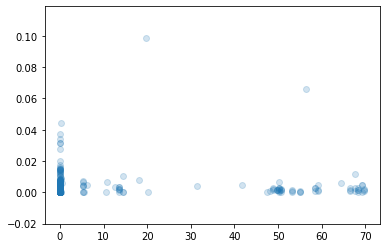

In [513]:
plt.scatter(missingDefault.missRate, missingDefault.impQ75Pond, alpha=0.2)

<BarContainer object of 202 artists>

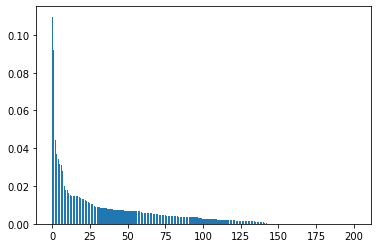

In [514]:
plt.bar([x for x in range(len(missingDefault))], missingDefault.impQ75.sort_values(ascending=False))

In [515]:
missingDefault = missingDefault.sort_values('impQ75Pond', ascending=False).reset_index(drop=True)
missingDefault

,feature,missRate,impMean,impMedian,impQ75,impMax,impQ75Pond
0,EXT_SOURCE_3,19.828856,0.108542,0.108180,0.109614,0.118338,0.098746
1,EXT_SOURCE_1,56.464598,0.088163,0.086427,0.091798,0.097779,0.065882
2,EXT_SOURCE_2,0.213233,0.043802,0.043789,0.044553,0.046712,0.044506
3,DAYS_BIRTH,0.000000,0.033415,0.033100,0.037009,0.042903,0.037009
4,POSCASH_CNT_INSTALMENT_FUTURE,0.000000,0.032658,0.032753,0.034075,0.037519,0.034075
5,DAYS_EMPLOYED,0.000000,0.029153,0.029044,0.031613,0.039201,0.031613
6,DAYS_ID_PUBLISH,0.000000,0.030793,0.030007,0.031281,0.034233,0.031281
7,PREV_SELLERPLACE_AREA,0.000000,0.025460,0.025750,0.027745,0.030897,0.027745
8,BURO_AMT_CREDIT_SUM_DEBT,0.000000,0.018363,0.017959,0.020077,0.025083,0.020077
9,DAYS_REGISTRATION,0.000000,0.014905,0.014429,0.017697,0.027612,0.017697


#### Suppression de colonnes peu importantes avec un fort taux de valeurs manquantes

In [516]:
def_miss_col_to_del = []
for index, row in missingDefault.iterrows():
    if (index >= 50) & (row.missRate >= 40):
        def_miss_col_to_del.append(row.feature)

In [517]:
len(dfApplicationDefault.columns)

205

In [518]:
missingDefault

,feature,missRate,impMean,impMedian,impQ75,impMax,impQ75Pond
0,EXT_SOURCE_3,19.828856,0.108542,0.108180,0.109614,0.118338,0.098746
1,EXT_SOURCE_1,56.464598,0.088163,0.086427,0.091798,0.097779,0.065882
2,EXT_SOURCE_2,0.213233,0.043802,0.043789,0.044553,0.046712,0.044506
3,DAYS_BIRTH,0.000000,0.033415,0.033100,0.037009,0.042903,0.037009
4,POSCASH_CNT_INSTALMENT_FUTURE,0.000000,0.032658,0.032753,0.034075,0.037519,0.034075
5,DAYS_EMPLOYED,0.000000,0.029153,0.029044,0.031613,0.039201,0.031613
6,DAYS_ID_PUBLISH,0.000000,0.030793,0.030007,0.031281,0.034233,0.031281
7,PREV_SELLERPLACE_AREA,0.000000,0.025460,0.025750,0.027745,0.030897,0.027745
8,BURO_AMT_CREDIT_SUM_DEBT,0.000000,0.018363,0.017959,0.020077,0.025083,0.020077
9,DAYS_REGISTRATION,0.000000,0.014905,0.014429,0.017697,0.027612,0.017697


In [519]:
for col in def_miss_col_to_del:
    del dfApplicationDefault[col]
    missingDefault = missingDefault[~missingDefault['feature'].isin([col])]
del dfApplicationDefault['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = missingDefault.reset_index(drop=True)

### Sélection des meilleures variables

#### Mean imputer et ordinal encoder pour la suite de la sélection de variables

In [520]:
dfApplicationDefaultSvg = dfApplicationDefault.copy()
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [521]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [538]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

In [539]:
dfApplicationDefault = dfApplicationDefault.dropna()
dfApplicationWorked = dfApplicationWorked.dropna()
print(dfApplicationWorked.shape)
print(dfApplicationDefault.shape)

(49582, 63)
(14135, 157)


In [540]:
y_d = dfApplicationDefault['TARGET'].values
y_w = dfApplicationWorked['TARGET'].values
del dfApplicationDefault['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationDefault['SK_ID_CURR']
del dfApplicationWorked['SK_ID_CURR']

In [541]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# https://medium.com/@literallywords/sklearn-identity-transformer-fcc18bac0e98
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

def transformDf(df):
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if df.nunique()[col] > 100:
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')            
        
    numerical_ix = df.select_dtypes(include=['float64']).columns
    integer_ix = df.select_dtypes(include=['int64']).columns
    categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
    
    df[categorical_ix] = df[categorical_ix].replace(np.nan, 'missing')
    
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = OrdinalEncoder().fit_transform(df[[col]])
        elif df[col].dtypes == 'float64':
            df[col] = MinMaxScaler().fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if df.nunique()[col] > 100:
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')    
            
    # ne marche pas???
    if False:  
        for col in list(categorical_ix):
            ordinal_encoder = OrdinalEncoder()
            df[col] = ordinal_encoder.fit_transform(df[col])

        for col in list(numerical_ix):
            df[col] = MinMaxScaler().fit_transform(df[col])

        for col in df.columns:
            if dfApplicationDefaultMiss[col].dtypes == 'object':
                ordinal_encoder = OrdinalEncoder()
                df[col] = ordinal_encoder.fit_transform(df[[col]])
             
    # change l'ordre des colonnes
    if False:
        #t = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
        t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix), ('int', MinMaxScaler(), integer_ix)]
        col_transform = ColumnTransformer(transformers=t)
        pipeline = Pipeline(steps=[('prep',col_transform), ('i', SimpleImputer(strategy='mean'))])

        t = [('cat', OrdinalEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix), ('int', IdentityTransformer(), integer_ix)]
        col_transform = ColumnTransformer(transformers=t)
        pipeline = Pipeline(steps=[('prep',col_transform)])
    
        return pd.DataFrame(pipeline.fit_transform(df), columns=df.columns)
        
    return df

In [542]:
dfApplicationWorked = transformDf(dfApplicationWorked)
dfApplicationDefault = transformDf(dfApplicationDefault)

#### Over et undersampling

In [545]:
def OverUnder(X, y):
    
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler

    print(Counter(y))
    over = RandomOverSampler(sampling_strategy=0.3)
    X, y = over.fit_resample(X, y)
    print(Counter(y))
    under = RandomUnderSampler(sampling_strategy=0.5)
    X, y = under.fit_resample(X, y)
    print(Counter(y))
    
    return X, y

In [546]:
X_d = dfApplicationDefault.values
X_w = dfApplicationWorked.values

X_dcol = dfApplicationDefault.columns
X_wcol = dfApplicationWorked.columns

In [547]:
X_d, y_d = OverUnder(X_d, y_d)
X_w, y_w = OverUnder(X_w, y_w)

Counter({0: 13191, 1: 944})
Counter({0: 13191, 1: 3957})
Counter({0: 7914, 1: 3957})
Counter({0: 45876, 1: 3706})
Counter({0: 45876, 1: 13762})
Counter({0: 27524, 1: 13762})


#### Calcul des feature importance

In [548]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def feat_imp(X, y, col, model=DecisionTreeClassifier()):

    i = 0
    for _ in np.arange(10):
        model.fit(X, y)
        imp = model.feature_importances_
        if i == 0:
            importance = pd.DataFrame(imp)
        else:
            importance = pd.concat([importance,pd.DataFrame(imp)], axis=1)
        i += 1
        
    statImp = pd.DataFrame(col, columns=['feature'])
    
    statImp['impMean'] = np.mean(importance, axis=1)
    statImp['impMedian'] = np.median(importance, axis=1)
    statImp['impQ75'] = np.quantile(importance, 0.75, axis=1)
    statImp['impMax'] = np.max(importance, axis=1)
    
    statImp = statImp.sort_values('impMedian', ascending=False).reset_index(drop=True).reset_index(drop=False)
    statImp = statImp.rename(columns={'index':'classement'})
    statImp['classement'] = statImp.apply(lambda x: x.classement+1, axis=1)
    
    return statImp


def feat_perm_imp(X, y, col, model=DecisionTreeClassifier()):
    
    from sklearn.inspection import permutation_importance
    model.fit(X, y)
    results = permutation_importance(model, X, y, scoring='roc_auc')
    importance = pd.DataFrame(results.importances_mean, columns=['perm_imp'])
    importance['feature'] = col
    importance = importance[['feature','perm_imp']]
    
    importance = importance.sort_values('perm_imp', ascending=False).reset_index(drop=True).reset_index(drop=False)
    importance = importance.rename(columns={'index':'perm_classement'})
    importance['perm_classement'] = importance.apply(lambda x: x.perm_classement+1, axis=1)
    
    return importance

In [549]:
perm_imp_d = feat_perm_imp(X_d, y_d, X_dcol, RandomForestClassifier(n_estimators=200, max_depth=5))
perm_imp_w = feat_perm_imp(X_w, y_w, X_wcol, RandomForestClassifier(n_estimators=200, max_depth=5))

imp_d = feat_imp(X_d, y_d, X_dcol, RandomForestClassifier(n_estimators=200, max_depth=5))
imp_w = feat_imp(X_w, y_w, X_wcol, RandomForestClassifier(n_estimators=200, max_depth=5))

In [550]:
imp_d = imp_d.merge(perm_imp_d, left_on='feature', right_on='feature')
imp_w = imp_w.merge(perm_imp_w, left_on='feature', right_on='feature')
imp_d['diff_classement'] = imp_d.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp_w['diff_classement'] = imp_w.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp_d['best_classement'] = imp_d.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)
imp_w['best_classement'] = imp_w.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)

Sur le jeu Worked

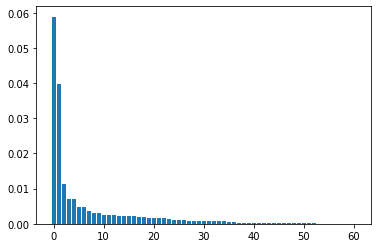

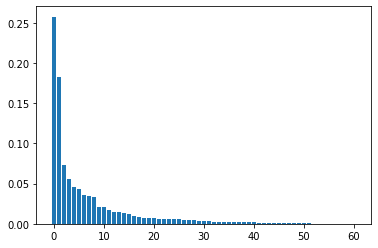

In [551]:
plt.bar([x for x in range(len(imp_w))], imp_w['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp_w))], imp_w['impMedian'].sort_values(ascending=False))
plt.show()

In [552]:
for index, row in imp_w.iterrows():
    if row.best_classement > 30:
        del dfApplicationWorkedSvg[row.feature]

Sur le jeu par défaut

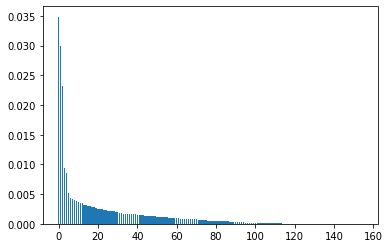

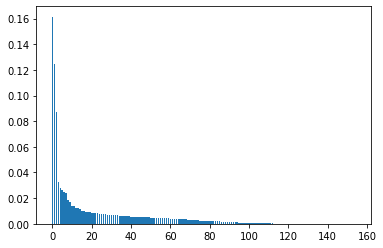

In [553]:
plt.bar([x for x in range(len(imp_d))], imp_d['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp_d))], imp_d['impMedian'].sort_values(ascending=False))
plt.show()

In [554]:
for index, row in imp_d.iterrows():
    if row.best_classement > 80:
        del dfApplicationDefaultSvg[row.feature]

In [555]:
dfApplicationDefault = dfApplicationDefaultSvg
dfApplicationWorked = dfApplicationWorkedSvg

### Détection des outliers

In [556]:
dfApplicationDefaultSvg = dfApplicationDefault.copy()
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [584]:
if False:
    dump(dfApplicationWorkedSvg, open('ApplicationWorkedOutlier.pkl','wb'))
    dump(dfApplicationDefaultSvg, open('ApplicationDefaultOutlier.pkl','wb'))

In [557]:
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXx

In [564]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

In [566]:
def removeOutliers(df):
    from numpy import percentile
    numerical_ix = list(df.select_dtypes(include=[ 'float64']).columns)
    print(df.shape)
    for col in numerical_ix:
        dataCol = df[~df[col].isnull()][col]
        q25, q75 = percentile(dataCol, 25), percentile(dataCol, 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        df = df[((df[col] >= lower) & (df[col] <= upper)) | df[col].isnull()]
        print('{}: {}'.format(col, df.shape[0]))
    return df

In [567]:
def outliersStat(df):
    from numpy import percentile
    numerical_ix = list(df.select_dtypes(include=['float64']).columns)
    dico = {}
    for col in numerical_ix:
        dataCol = df[~df[col].isnull()][col]
        q25, q75 = percentile(dataCol, 25), percentile(dataCol, 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        dico[col] = df[((df[col] < lower) | (df[col] > upper))].shape[0]
    return dico

In [568]:
dfApplicationWorked.shape

(215257, 34)

In [572]:
statOutlierD = outliersStat(dfApplicationDefault)
statOutlierD = pd.DataFrame({'feature': pd.Series(list(statOutlierD.keys())), 'nb_outliers': pd.Series(list(statOutlierD.values()))}).sort_values('nb_outliers', ascending=False)

statOutlierW = outliersStat(dfApplicationWorked)
statOutlierW = pd.DataFrame({'feature': pd.Series(list(statOutlierW.keys())), 'nb_outliers': pd.Series(list(statOutlierW.values()))}).sort_values('nb_outliers', ascending=False)

In [590]:
dfApplicationWorkedSvg[['NAME_EDUCATION_TYPE']].dtypes

NAME_EDUCATION_TYPE    float64
dtype: object


---------------------------------------------------------------------
BURO_AMT_CREDIT_MAX_OVERDUE:49316


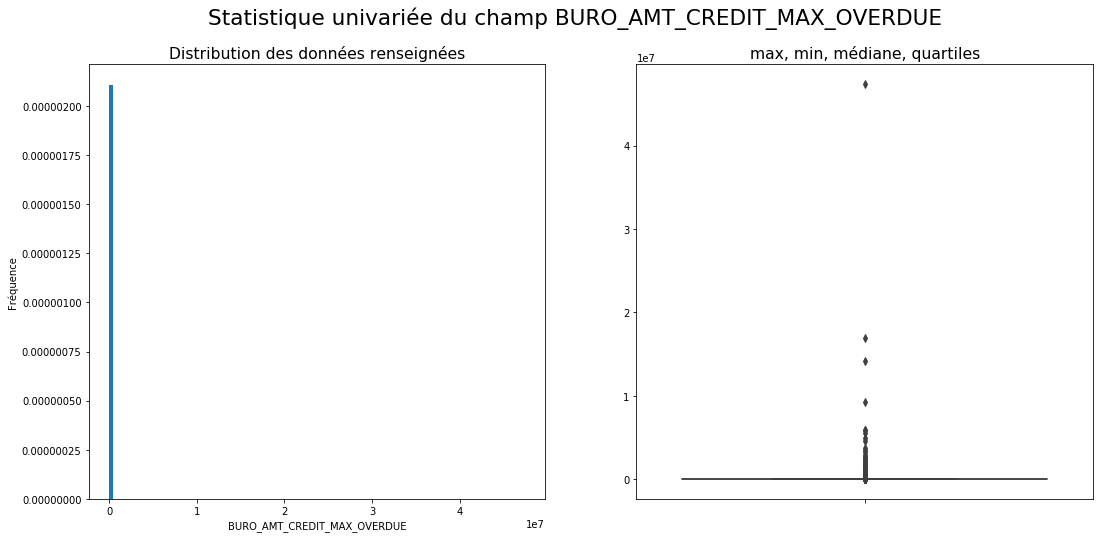

Mesures de position
 - Moyenne: 2759.67
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 120831.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 305.75
 - Kurtosis (applatissement): 112969.99


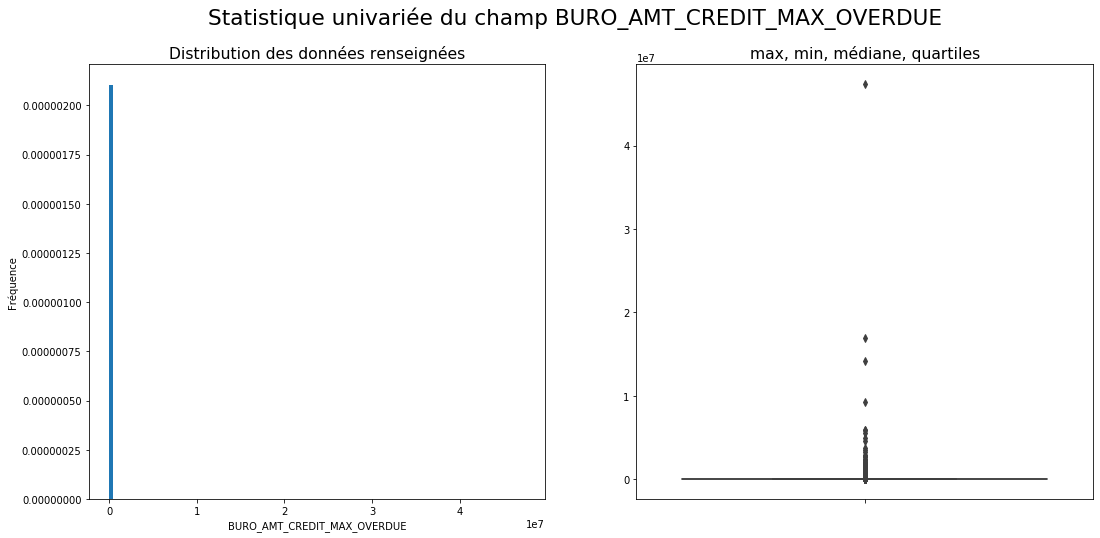

Mesures de position
 - Moyenne: 12045.57
 - Médiane: 3501.0
Mesures de dispertion
 - Ecart type: 252222.93
 - Min: 0.01
 - Q25: 1424.9
 - Q75: 7607.82
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 146.62
 - Kurtosis (applatissement): 25948.93

---------------------------------------------------------------------
DIFF_AMT_INSTALLMENT_PAYMENT:43326


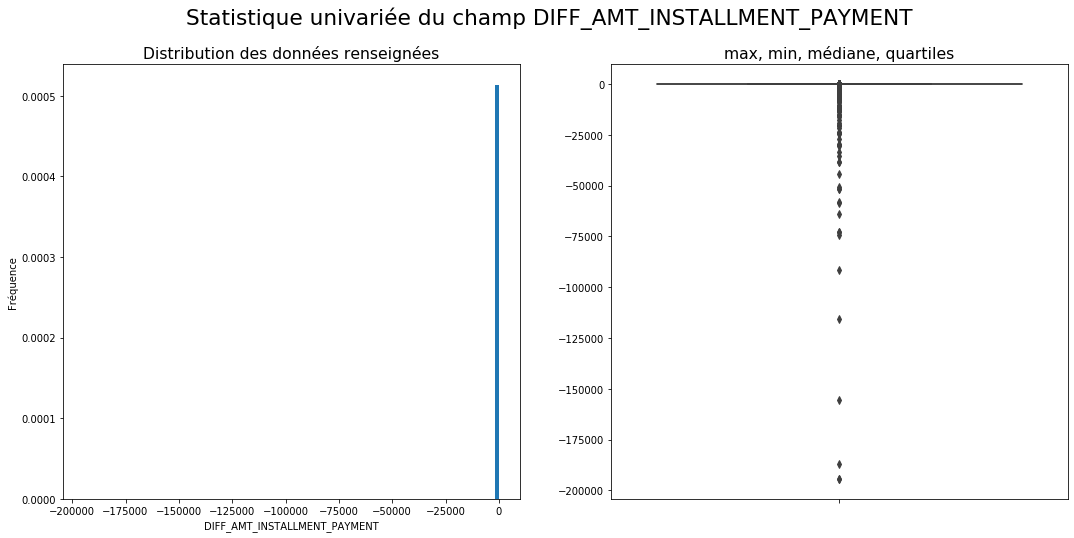

Mesures de position
 - Moyenne: -13.35
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1021.9
 - Min: -194415.46
 - Q25: 0.0
 - Q75: 1.67
 - Max: 81.17
Mesures de forme
 - Skewness (asymétrie): -138.97
 - Kurtosis (applatissement): 22929.89


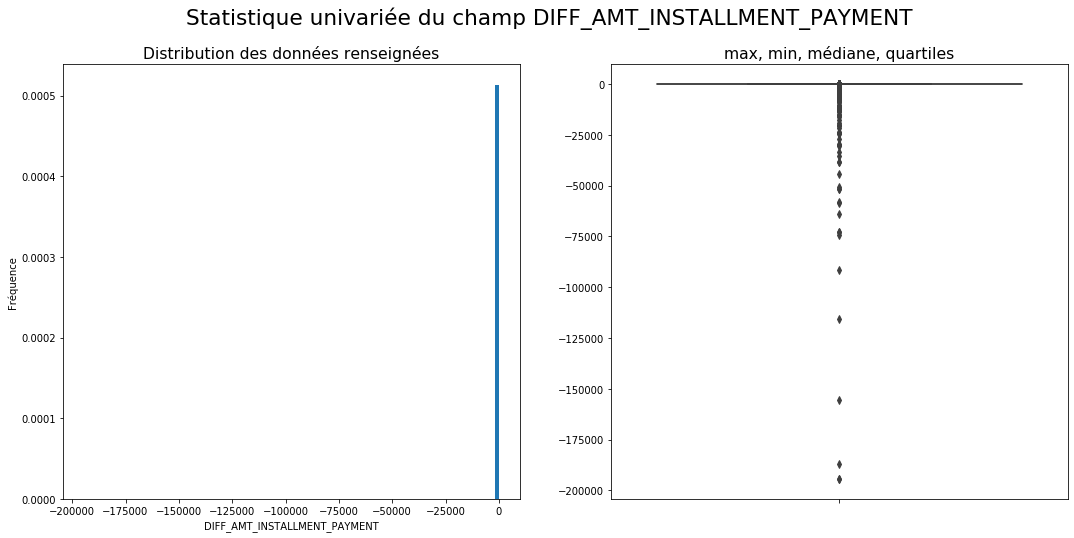

Mesures de position
 - Moyenne: -27.39
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 1463.58
 - Min: -194415.46
 - Q25: 1.0
 - Q75: 4.0
 - Max: 81.17
Mesures de forme
 - Skewness (asymétrie): -97.02
 - Kurtosis (applatissement): 11175.29

---------------------------------------------------------------------
BURO_CREDIT_ACTIVE:30923


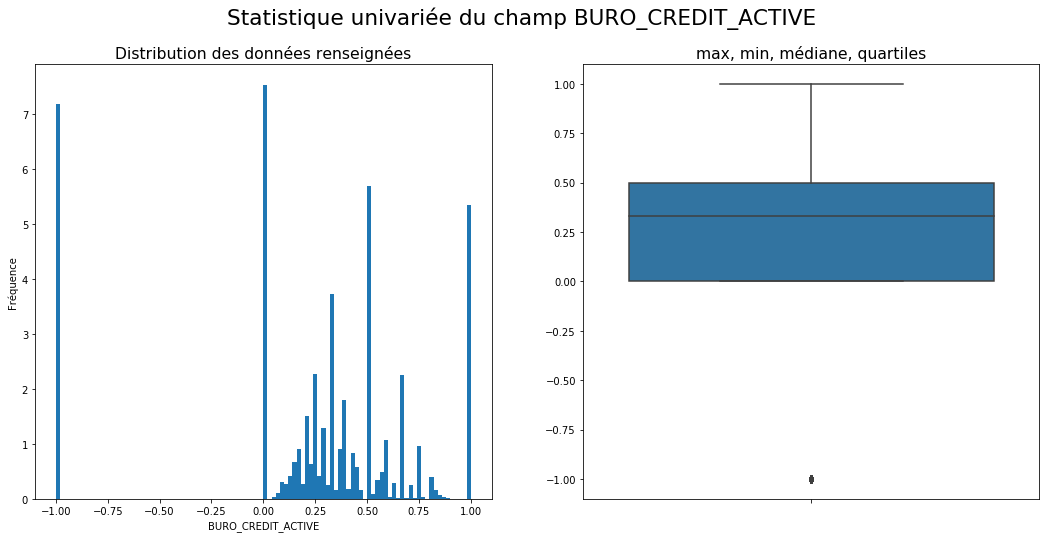

Mesures de position
 - Moyenne: 0.21
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.57
 - Min: -1.0
 - Q25: 0.0
 - Q75: 0.5
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -0.99
 - Kurtosis (applatissement): 0.34


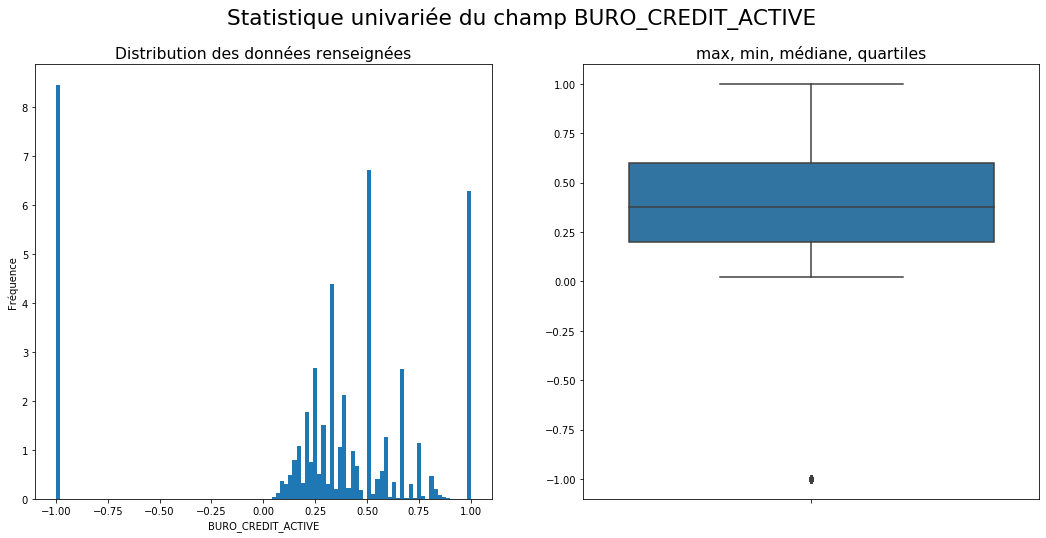

Mesures de position
 - Moyenne: 0.25
 - Médiane: 0.38
Mesures de dispertion
 - Ecart type: 0.61
 - Min: -1.0
 - Q25: 0.2
 - Q75: 0.6
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -1.13
 - Kurtosis (applatissement): 0.23

---------------------------------------------------------------------
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG:28672


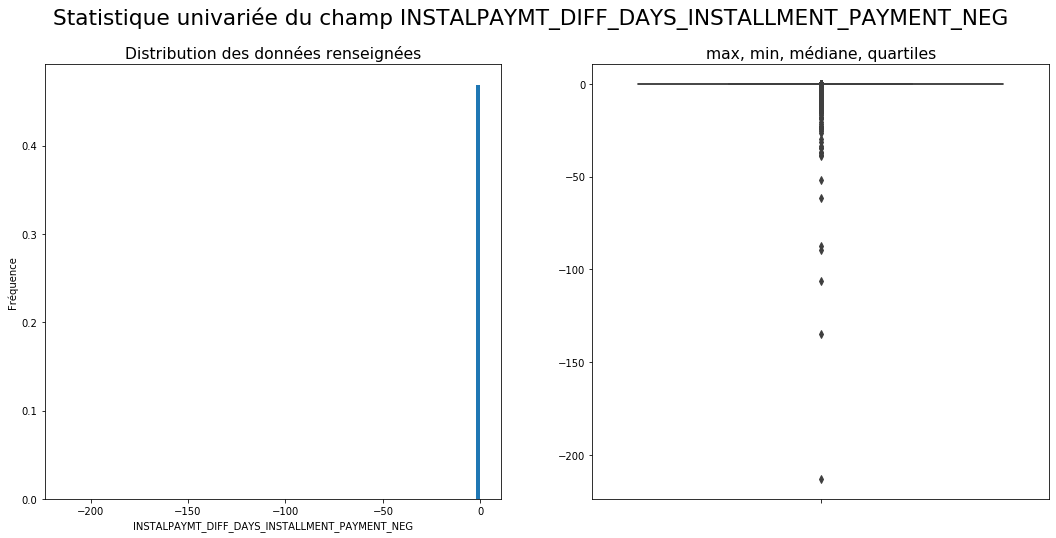

Mesures de position
 - Moyenne: -0.04
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.77
 - Min: -212.98
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -162.18
 - Kurtosis (applatissement): 36127.87


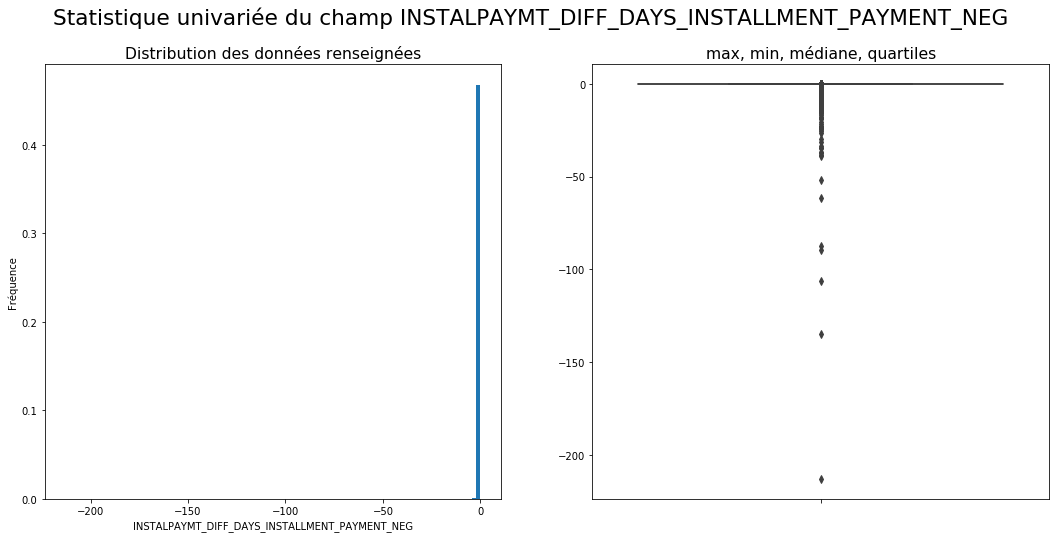

Mesures de position
 - Moyenne: -0.08
 - Médiane: -0.02
Mesures de dispertion
 - Ecart type: 1.09
 - Min: -212.98
 - Q25: -0.05
 - Q75: -0.01
 - Max: -0.0
Mesures de forme
 - Skewness (asymétrie): -113.68
 - Kurtosis (applatissement): 17718.95

---------------------------------------------------------------------
BURO_DAYS_CREDIT_ENDDATE:27161


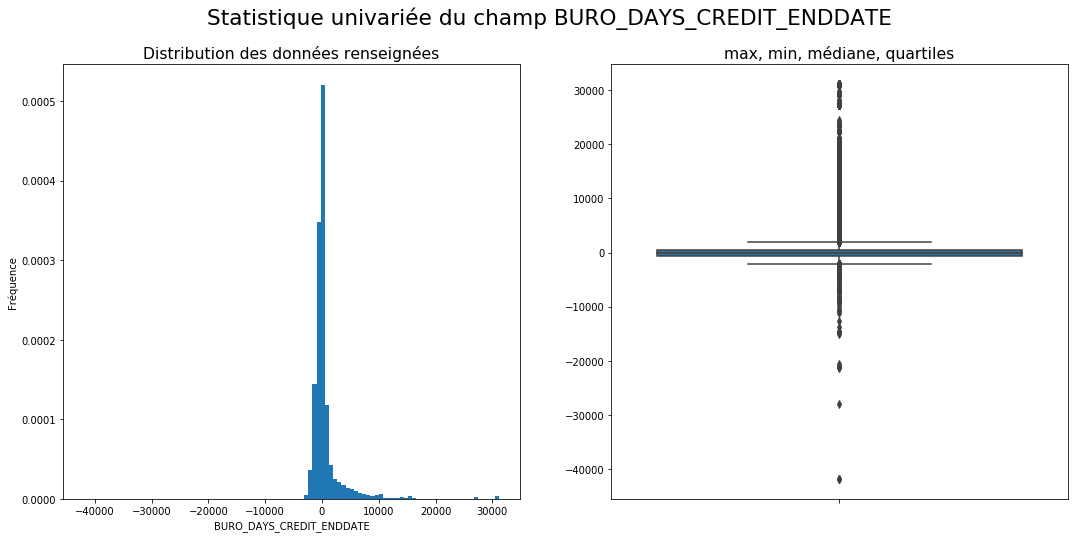

Mesures de position
 - Moyenne: 559.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3051.48
 - Min: -41875.0
 - Q25: -593.17
 - Q75: 404.33
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.35
 - Kurtosis (applatissement): 40.64


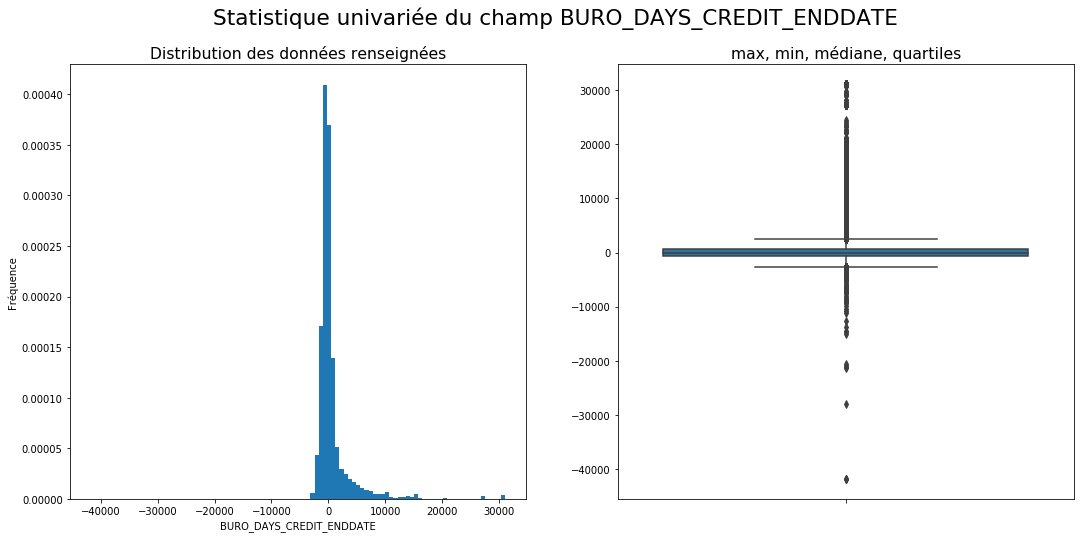

Mesures de position
 - Moyenne: 658.72
 - Médiane: -135.15
Mesures de dispertion
 - Ecart type: 3302.51
 - Min: -41875.0
 - Q25: -703.0
 - Q75: 602.27
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 4.88
 - Kurtosis (applatissement): 33.88

---------------------------------------------------------------------
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS:26101


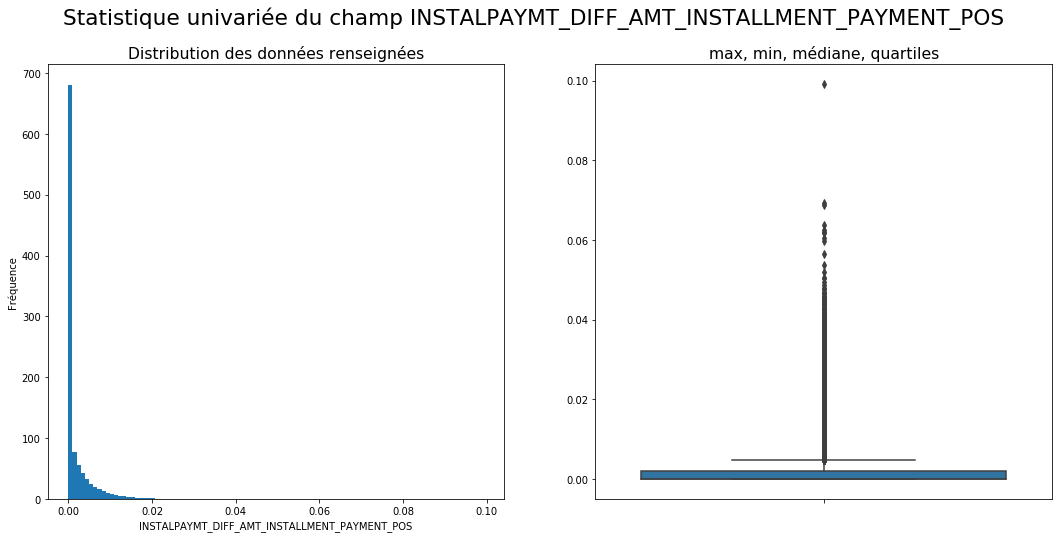

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 3.8
 - Kurtosis (applatissement): 25.25


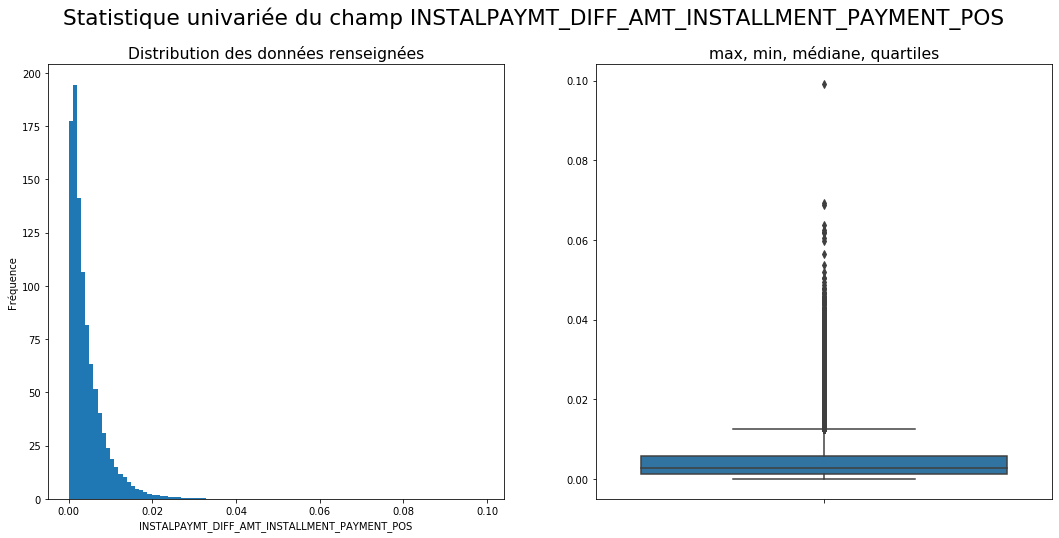

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 15.46

---------------------------------------------------------------------
BUROBAL_STATUS_BUREAU_DPD:21610


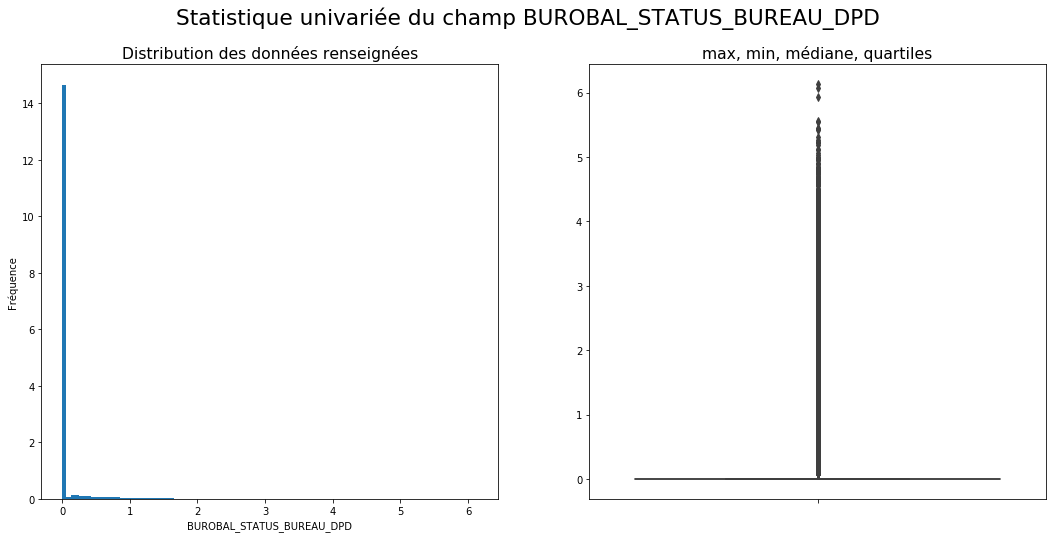

Mesures de position
 - Moyenne: 0.09
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.36
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 6.14
Mesures de forme
 - Skewness (asymétrie): 6.29
 - Kurtosis (applatissement): 50.36


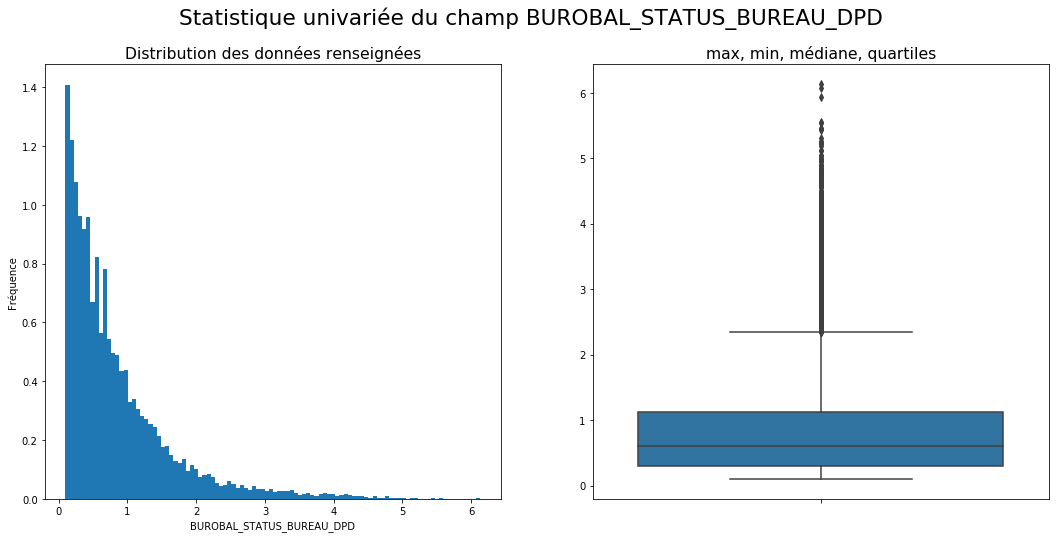

Mesures de position
 - Moyenne: 0.85
 - Médiane: 0.61
Mesures de dispertion
 - Ecart type: 0.79
 - Min: 0.1
 - Q25: 0.3
 - Q75: 1.12
 - Max: 6.14
Mesures de forme
 - Skewness (asymétrie): 2.03
 - Kurtosis (applatissement): 5.06

---------------------------------------------------------------------
PREV_AMT_CREDIT_STD_LOG:14299


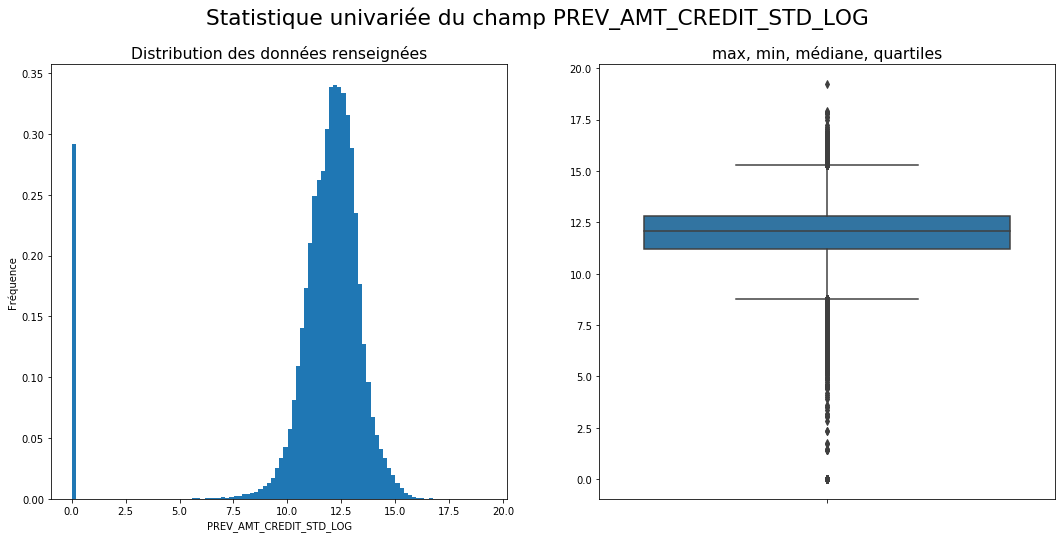

Mesures de position
 - Moyenne: 11.43
 - Médiane: 12.08
Mesures de dispertion
 - Ecart type: 3.01
 - Min: 0.0
 - Q25: 11.21
 - Q75: 12.83
 - Max: 19.25
Mesures de forme
 - Skewness (asymétrie): -2.98
 - Kurtosis (applatissement): 8.79


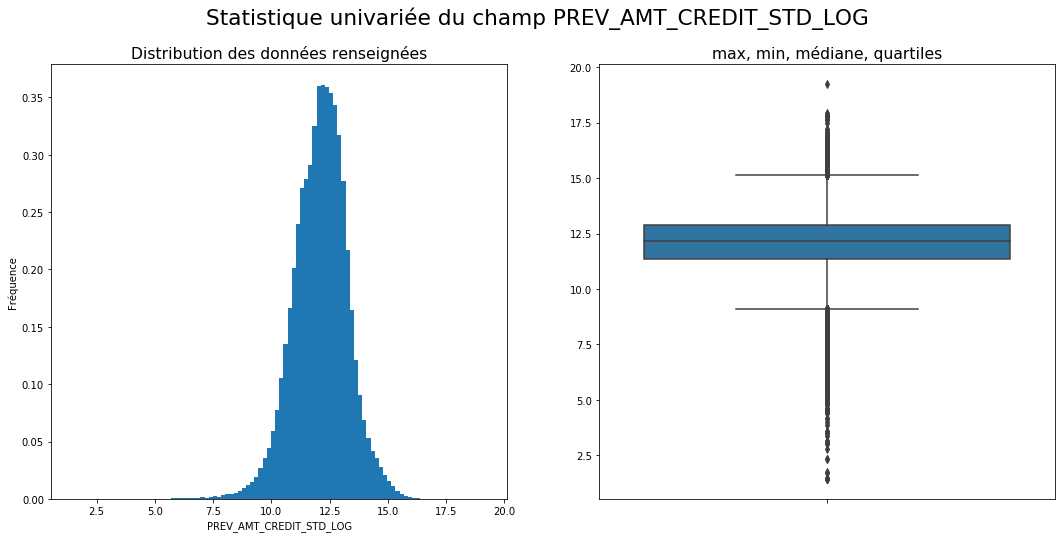

Mesures de position
 - Moyenne: 12.11
 - Médiane: 12.17
Mesures de dispertion
 - Ecart type: 1.17
 - Min: 1.43
 - Q25: 11.37
 - Q75: 12.88
 - Max: 19.25
Mesures de forme
 - Skewness (asymétrie): -0.37
 - Kurtosis (applatissement): 1.68

---------------------------------------------------------------------
DIFF_DAYS_INSTALLMENT_PAYMENT:13936


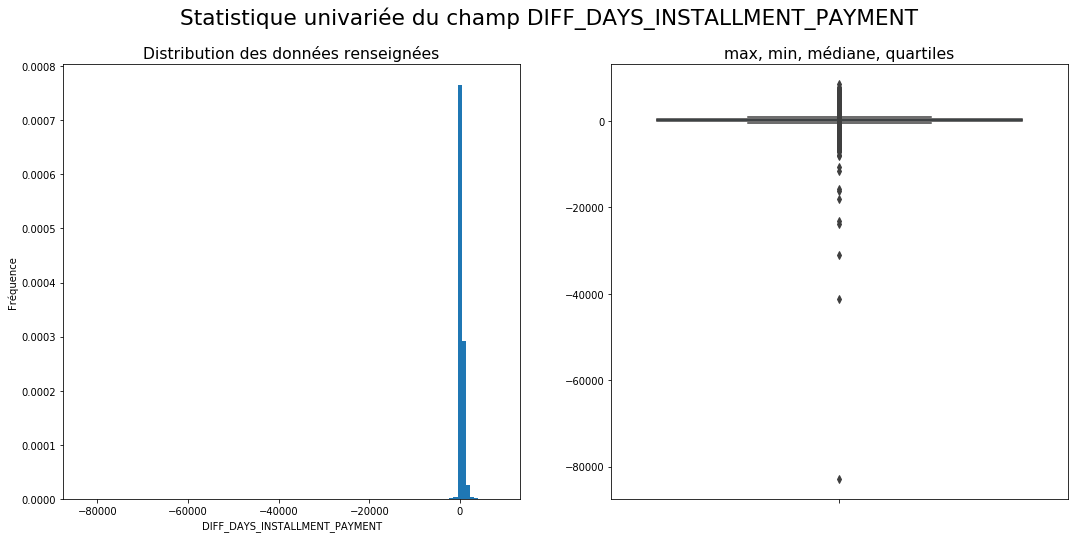

Mesures de position
 - Moyenne: 340.99
 - Médiane: 236.0
Mesures de dispertion
 - Ecart type: 473.34
 - Min: -82910.0
 - Q25: 116.0
 - Q75: 453.0
 - Max: 8640.0
Mesures de forme
 - Skewness (asymétrie): -32.6
 - Kurtosis (applatissement): 5221.33


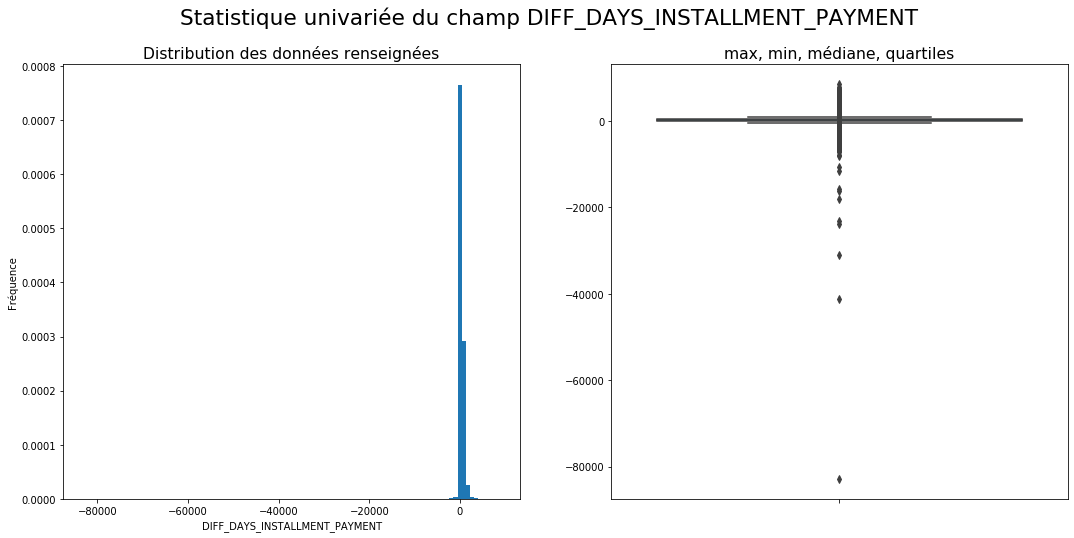

Mesures de position
 - Moyenne: 341.52
 - Médiane: 237.0
Mesures de dispertion
 - Ecart type: 473.52
 - Min: -82910.0
 - Q25: 116.0
 - Q75: 454.0
 - Max: 8640.0
Mesures de forme
 - Skewness (asymétrie): -32.62
 - Kurtosis (applatissement): 5221.79

---------------------------------------------------------------------
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS:12822


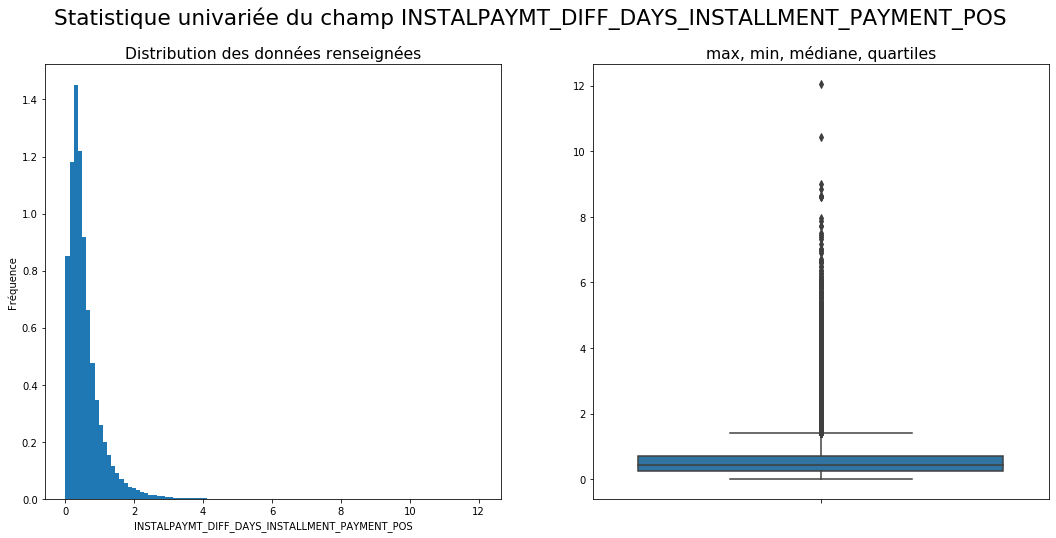

Mesures de position
 - Moyenne: 0.56
 - Médiane: 0.42
Mesures de dispertion
 - Ecart type: 0.52
 - Min: 0.0
 - Q25: 0.24
 - Q75: 0.71
 - Max: 12.05
Mesures de forme
 - Skewness (asymétrie): 2.96
 - Kurtosis (applatissement): 17.82


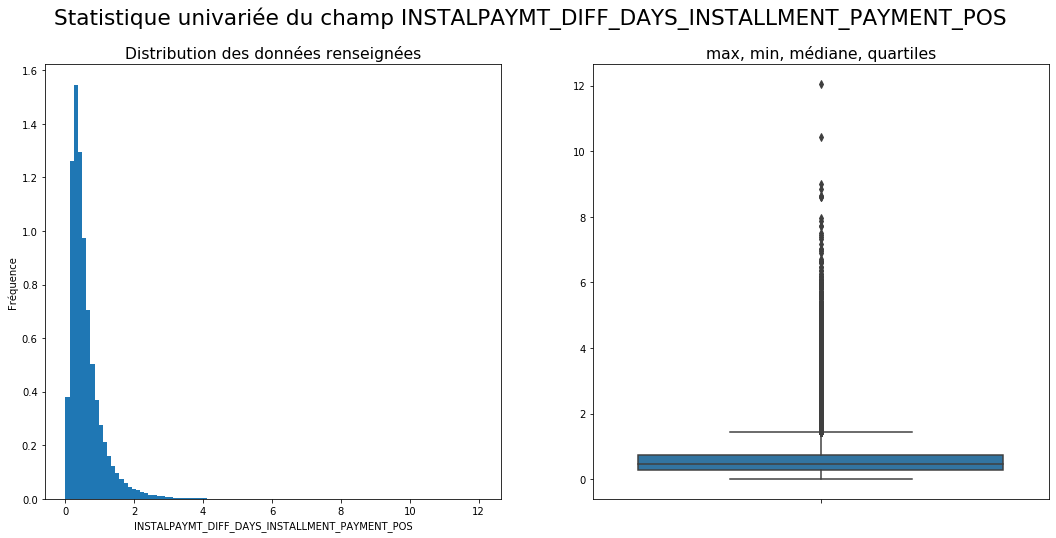

Mesures de position
 - Moyenne: 0.59
 - Médiane: 0.45
Mesures de dispertion
 - Ecart type: 0.51
 - Min: 0.0
 - Q25: 0.28
 - Q75: 0.74
 - Max: 12.05
Mesures de forme
 - Skewness (asymétrie): 3.1
 - Kurtosis (applatissement): 18.88

---------------------------------------------------------------------
PREV_NAME_CONTRACT_STATUS:12731


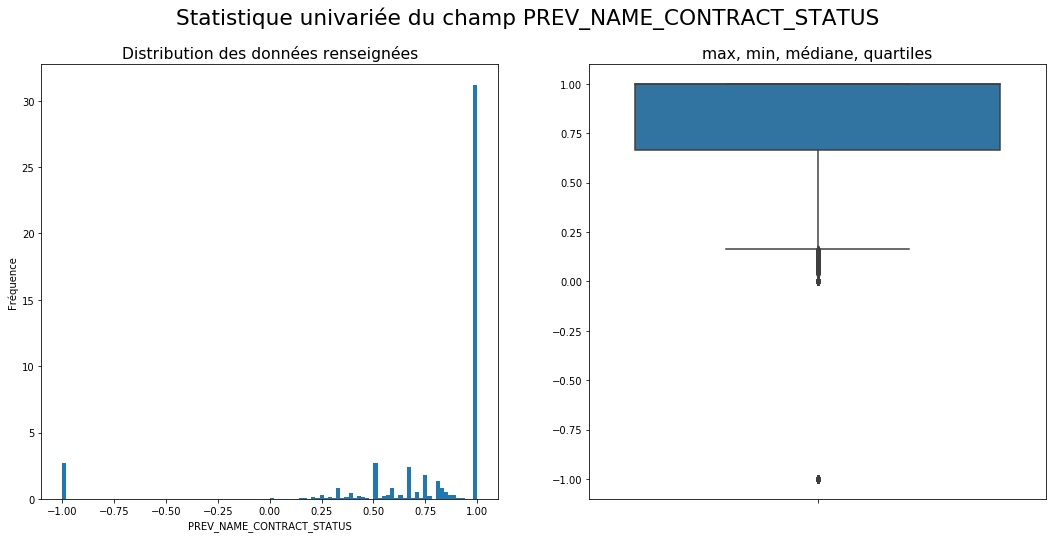

Mesures de position
 - Moyenne: 0.77
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.47
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.85
 - Kurtosis (applatissement): 7.78


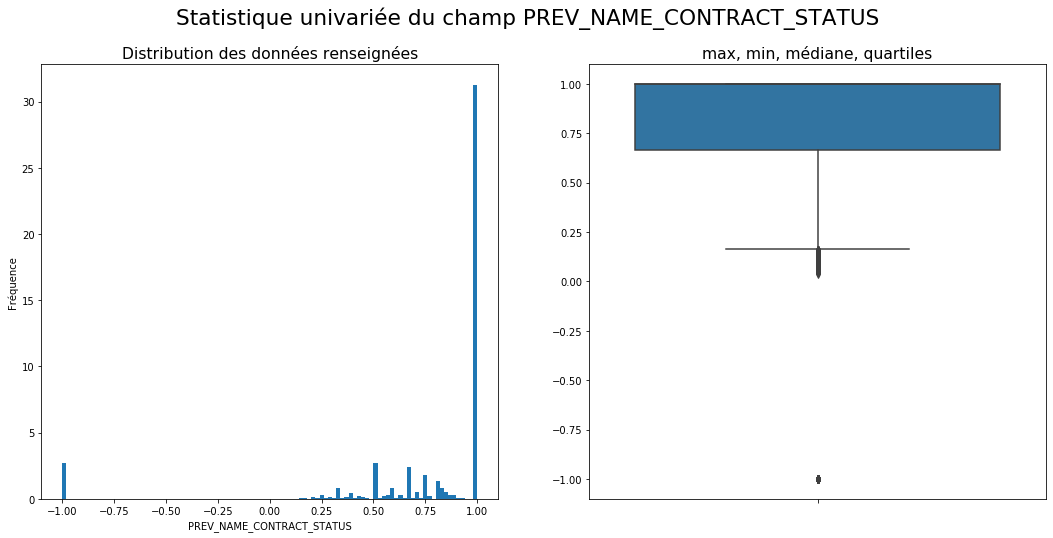

Mesures de position
 - Moyenne: 0.77
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.47
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.87
 - Kurtosis (applatissement): 7.89

---------------------------------------------------------------------
PREV_AMT_CREDIT_LOG:11683


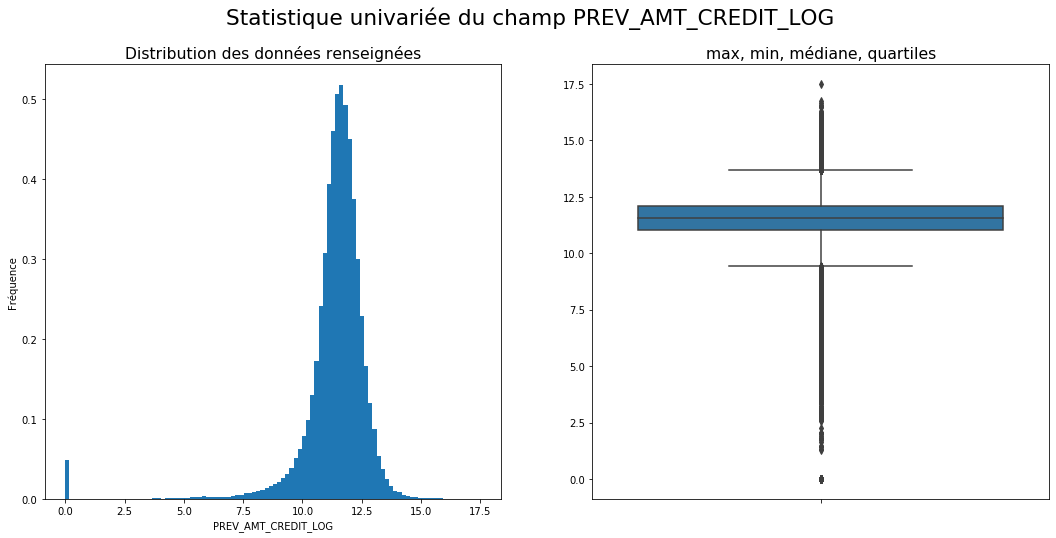

Mesures de position
 - Moyenne: 11.38
 - Médiane: 11.57
Mesures de dispertion
 - Ecart type: 1.5
 - Min: 0.0
 - Q25: 11.02
 - Q75: 12.08
 - Max: 17.5
Mesures de forme
 - Skewness (asymétrie): -4.21
 - Kurtosis (applatissement): 27.98


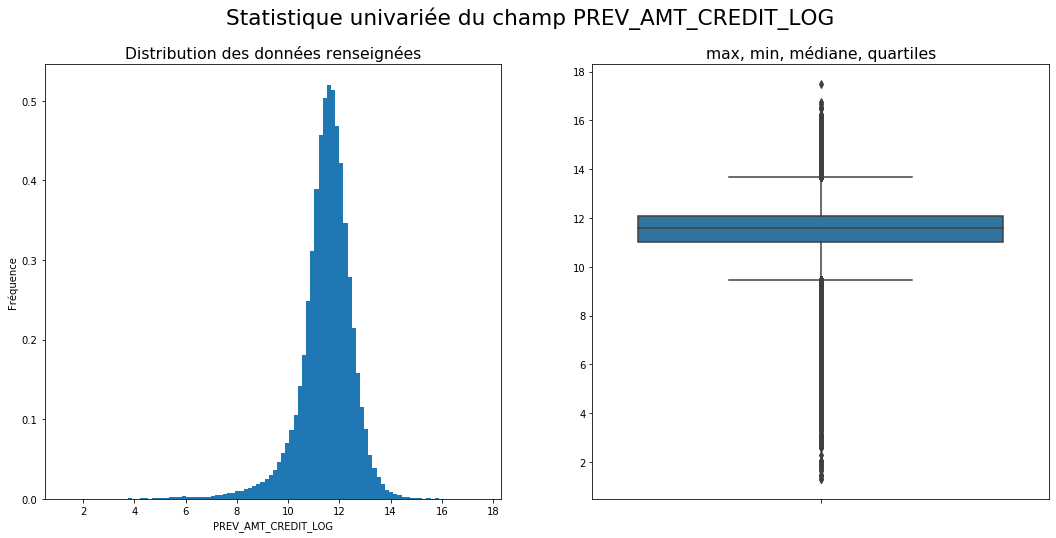

Mesures de position
 - Moyenne: 11.48
 - Médiane: 11.58
Mesures de dispertion
 - Ecart type: 1.07
 - Min: 1.3
 - Q25: 11.03
 - Q75: 12.09
 - Max: 17.5
Mesures de forme
 - Skewness (asymétrie): -1.56
 - Kurtosis (applatissement): 7.27

---------------------------------------------------------------------
PREV_DAYS_DIFF:10551


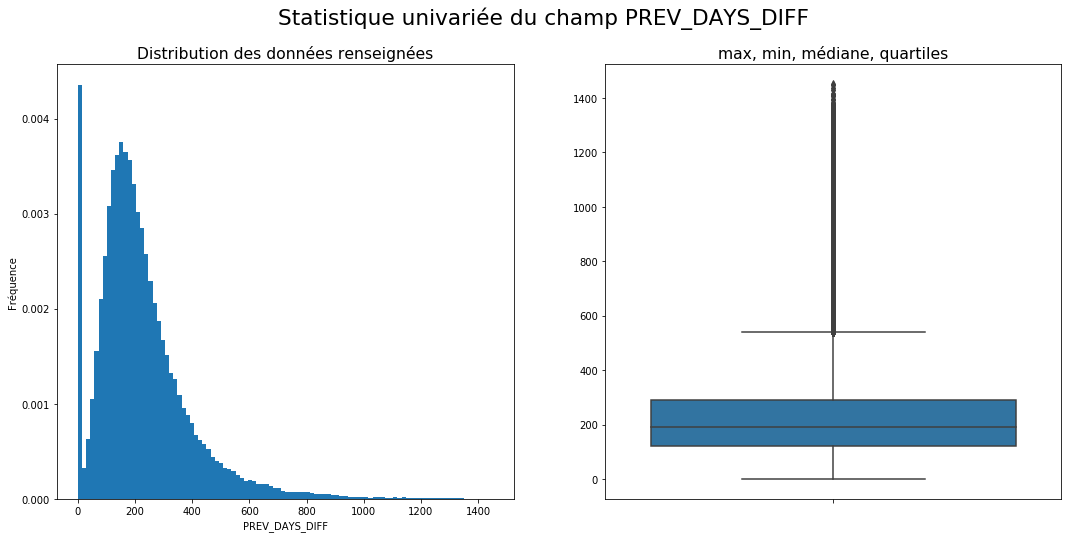

Mesures de position
 - Moyenne: 226.15
 - Médiane: 191.75
Mesures de dispertion
 - Ecart type: 166.34
 - Min: 0.0
 - Q25: 122.83
 - Q75: 290.33
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 5.78


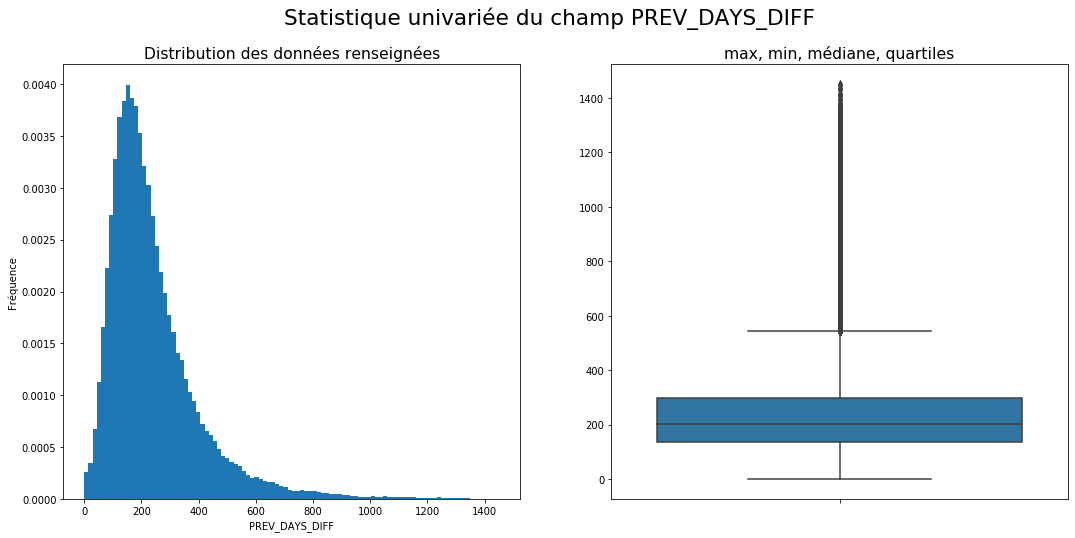

Mesures de position
 - Moyenne: 240.5
 - Médiane: 200.8
Mesures de dispertion
 - Ecart type: 161.17
 - Min: 0.17
 - Q25: 135.37
 - Q75: 299.12
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 2.05
 - Kurtosis (applatissement): 6.57

---------------------------------------------------------------------
POSCASH_NB_POS_CASH_BALANCE:9939


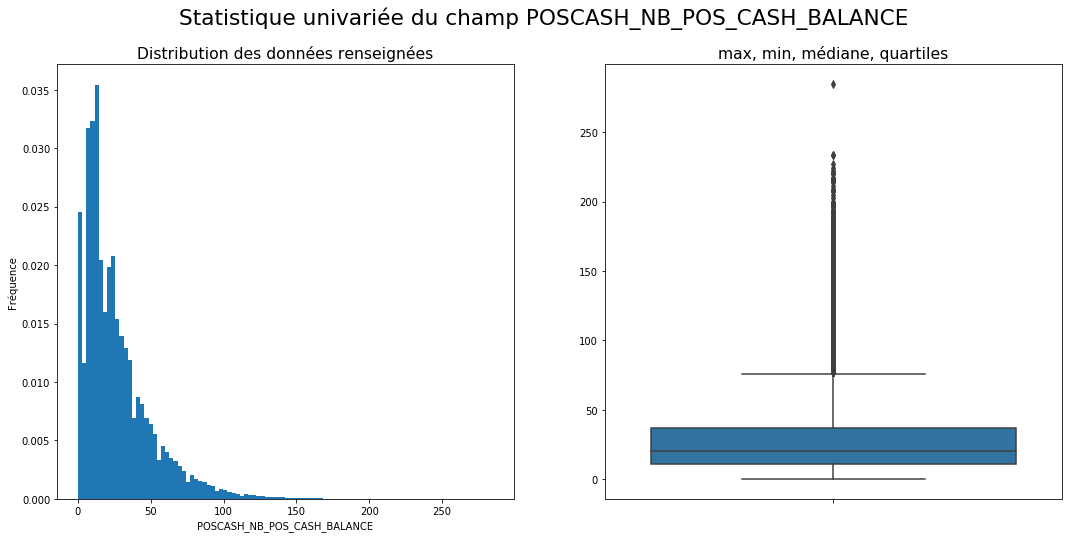

Mesures de position
 - Moyenne: 26.83
 - Médiane: 20.0
Mesures de dispertion
 - Ecart type: 23.81
 - Min: 0.0
 - Q25: 11.0
 - Q75: 37.0
 - Max: 285.0
Mesures de forme
 - Skewness (asymétrie): 1.77
 - Kurtosis (applatissement): 4.47


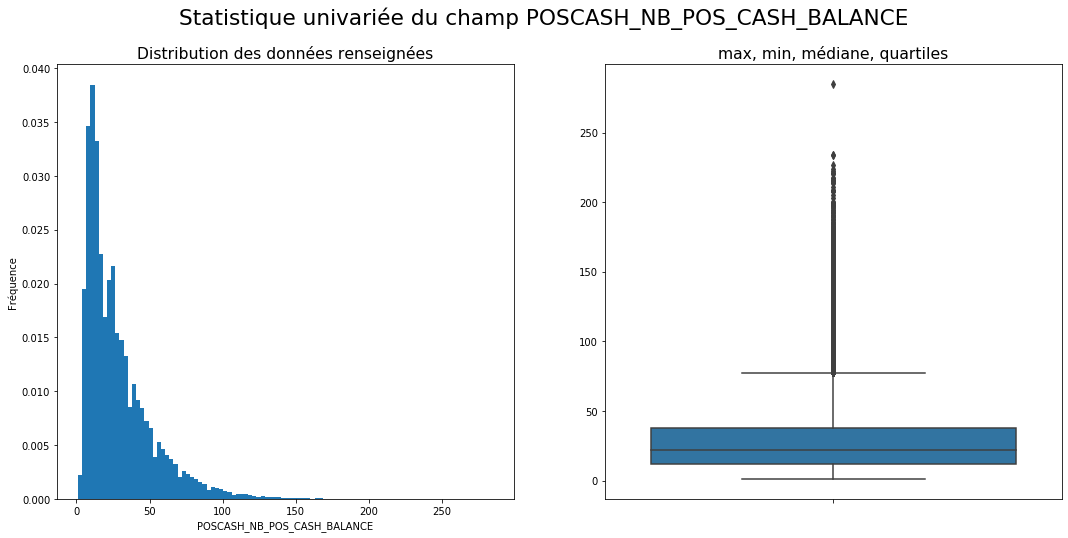

Mesures de position
 - Moyenne: 28.76
 - Médiane: 22.0
Mesures de dispertion
 - Ecart type: 23.49
 - Min: 1.0
 - Q25: 12.0
 - Q75: 38.0
 - Max: 285.0
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 4.67

---------------------------------------------------------------------
PREV_RATE_DOWN_PAYMENT:7765


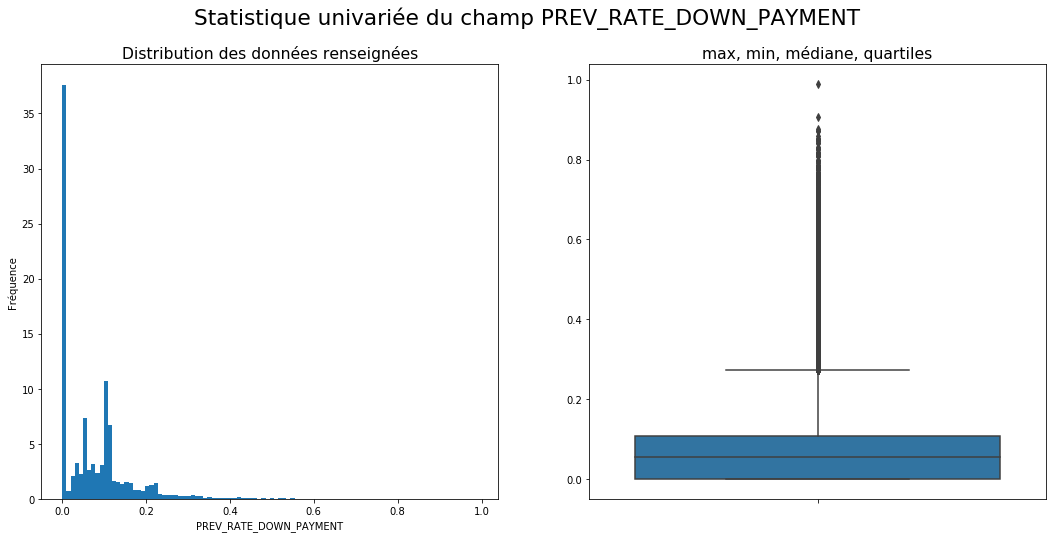

Mesures de position
 - Moyenne: 0.07
 - Médiane: 0.05
Mesures de dispertion
 - Ecart type: 0.09
 - Min: -0.0
 - Q25: 0.0
 - Q75: 0.11
 - Max: 0.99
Mesures de forme
 - Skewness (asymétrie): 2.08
 - Kurtosis (applatissement): 6.99


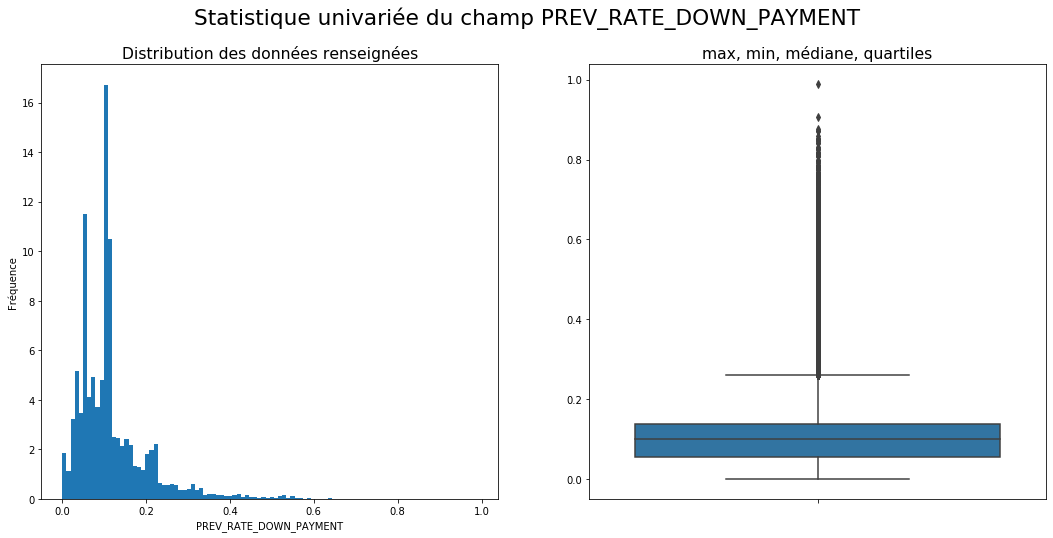

Mesures de position
 - Moyenne: 0.12
 - Médiane: 0.1
Mesures de dispertion
 - Ecart type: 0.09
 - Min: -0.0
 - Q25: 0.06
 - Q75: 0.14
 - Max: 0.99
Mesures de forme
 - Skewness (asymétrie): 2.29
 - Kurtosis (applatissement): 8.08

---------------------------------------------------------------------
APARTMENTS_MODE:7233


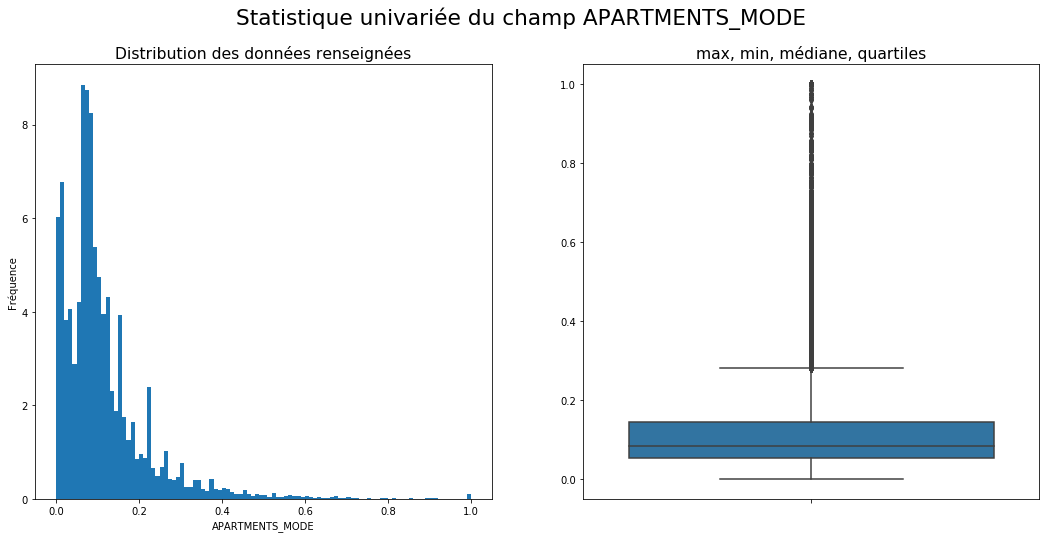

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.08
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.14
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.7
 - Kurtosis (applatissement): 11.74


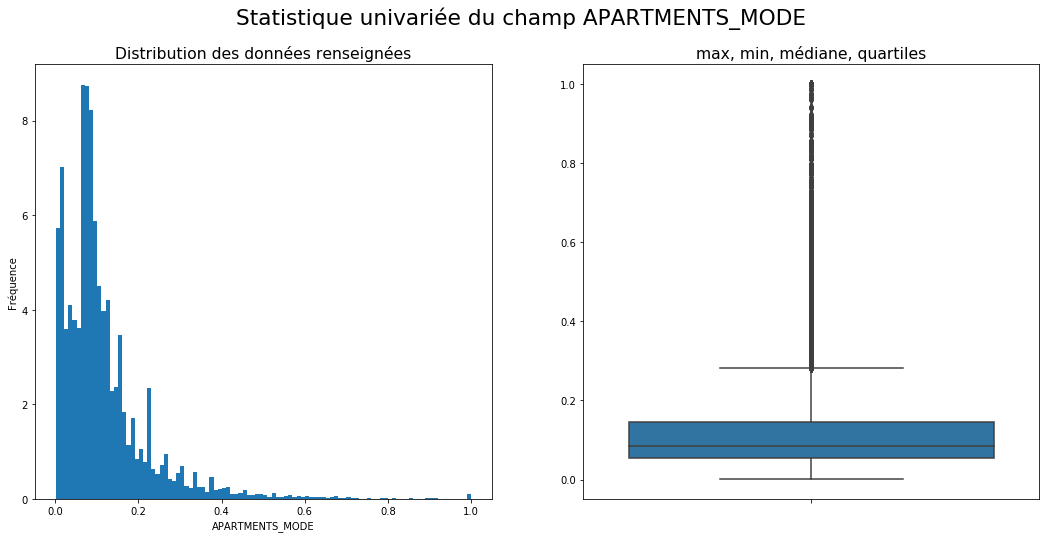

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.08
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.14
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.71
 - Kurtosis (applatissement): 11.78

---------------------------------------------------------------------
RATIO_ANNUITY_INCOME:5509


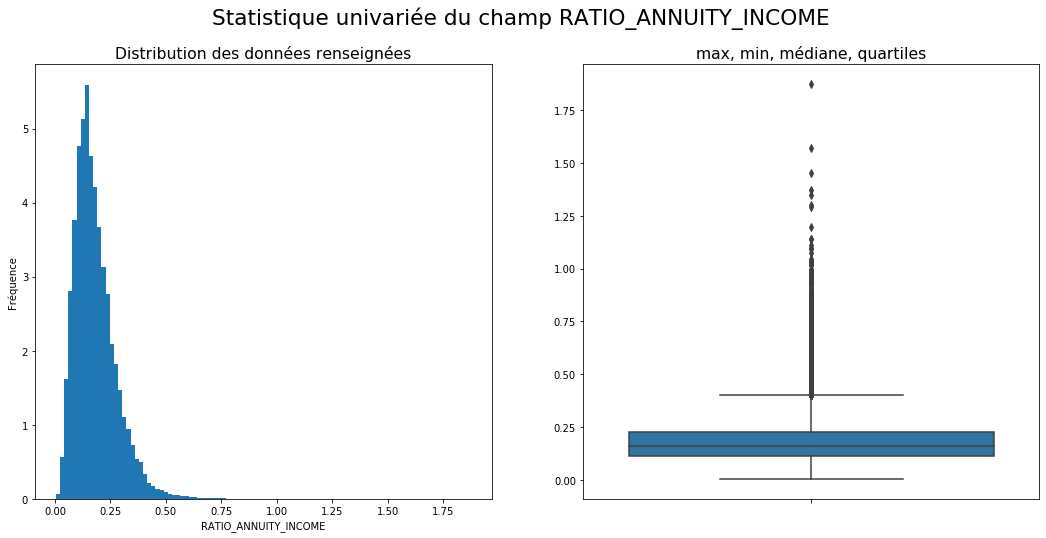

Mesures de position
 - Moyenne: 0.18
 - Médiane: 0.16
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.11
 - Q75: 0.23
 - Max: 1.88
Mesures de forme
 - Skewness (asymétrie): 1.52
 - Kurtosis (applatissement): 5.62


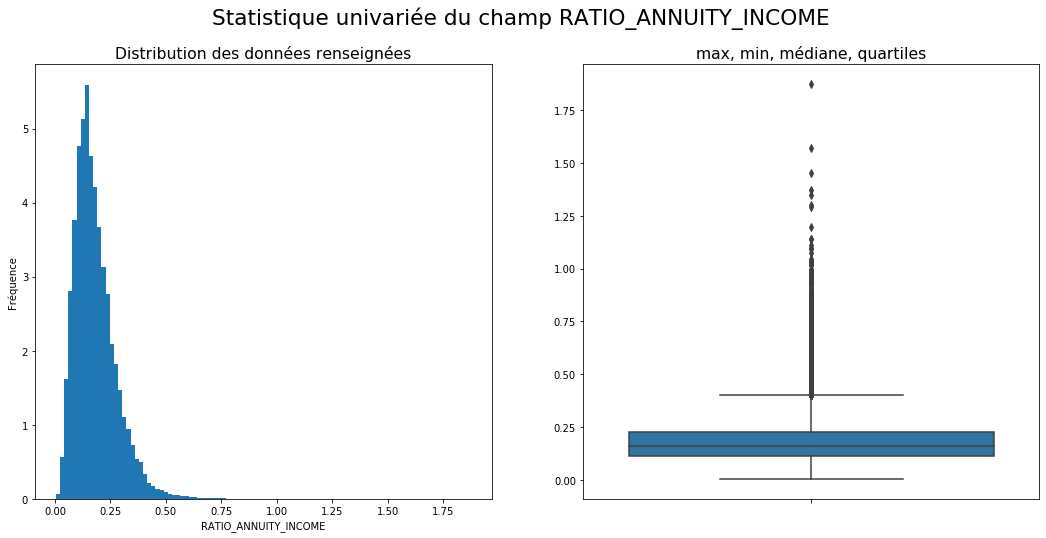

Mesures de position
 - Moyenne: 0.18
 - Médiane: 0.16
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.11
 - Q75: 0.23
 - Max: 1.88
Mesures de forme
 - Skewness (asymétrie): 1.52
 - Kurtosis (applatissement): 5.62

---------------------------------------------------------------------
BURO_NB_BUREAU:4991


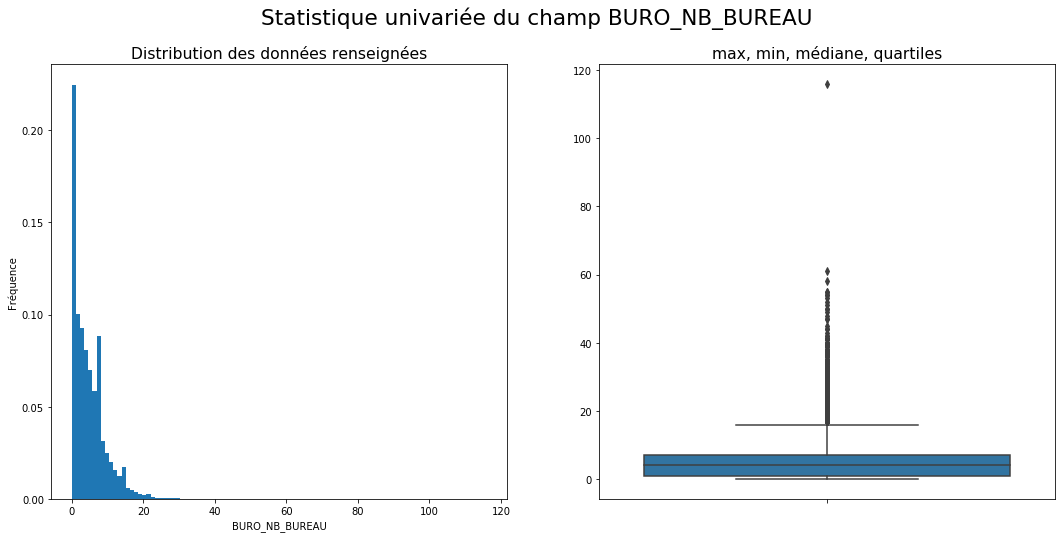

Mesures de position
 - Moyenne: 4.77
 - Médiane: 4.0
Mesures de dispertion
 - Ecart type: 4.5
 - Min: 0.0
 - Q25: 1.0
 - Q75: 7.0
 - Max: 116.0
Mesures de forme
 - Skewness (asymétrie): 1.69
 - Kurtosis (applatissement): 6.26


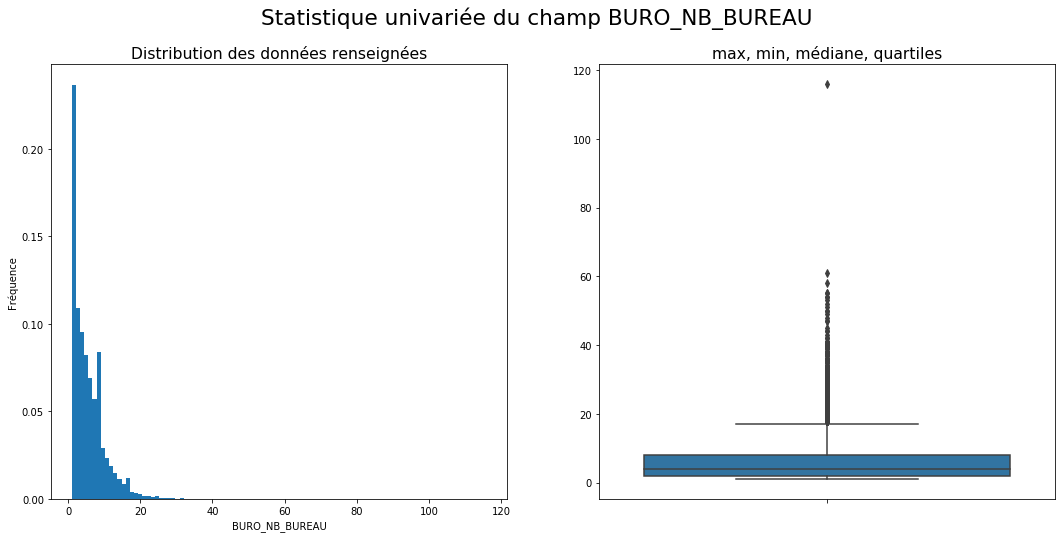

Mesures de position
 - Moyenne: 5.56
 - Médiane: 4.0
Mesures de dispertion
 - Ecart type: 4.38
 - Min: 1.0
 - Q25: 2.0
 - Q75: 8.0
 - Max: 116.0
Mesures de forme
 - Skewness (asymétrie): 1.81
 - Kurtosis (applatissement): 7.28

---------------------------------------------------------------------
AMT_CREDIT:4580


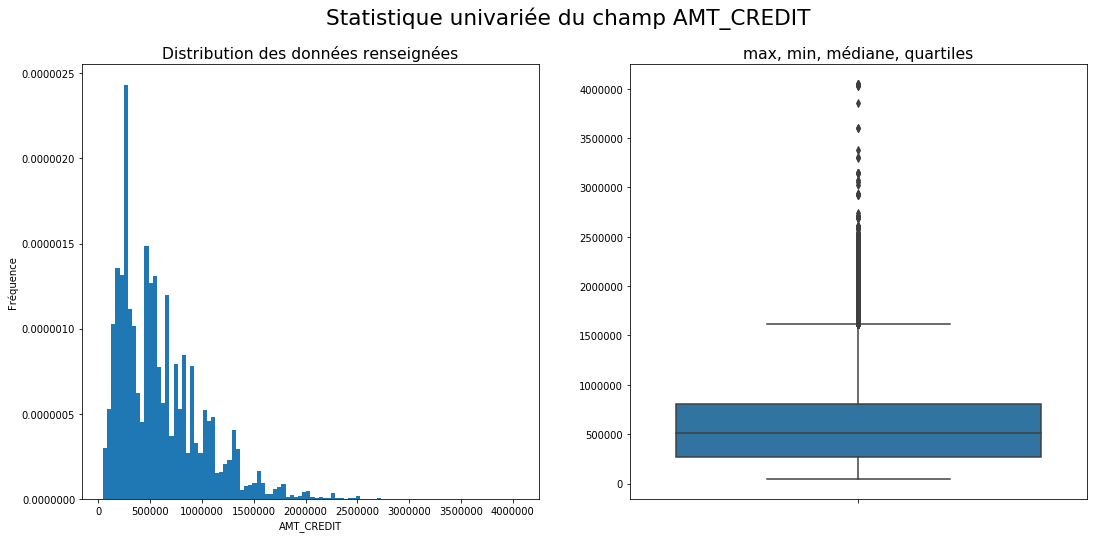

Mesures de position
 - Moyenne: 598734.88
 - Médiane: 513531.0
Mesures de dispertion
 - Ecart type: 402435.05
 - Min: 45000.0
 - Q25: 270000.0
 - Q75: 808650.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.24
 - Kurtosis (applatissement): 1.94


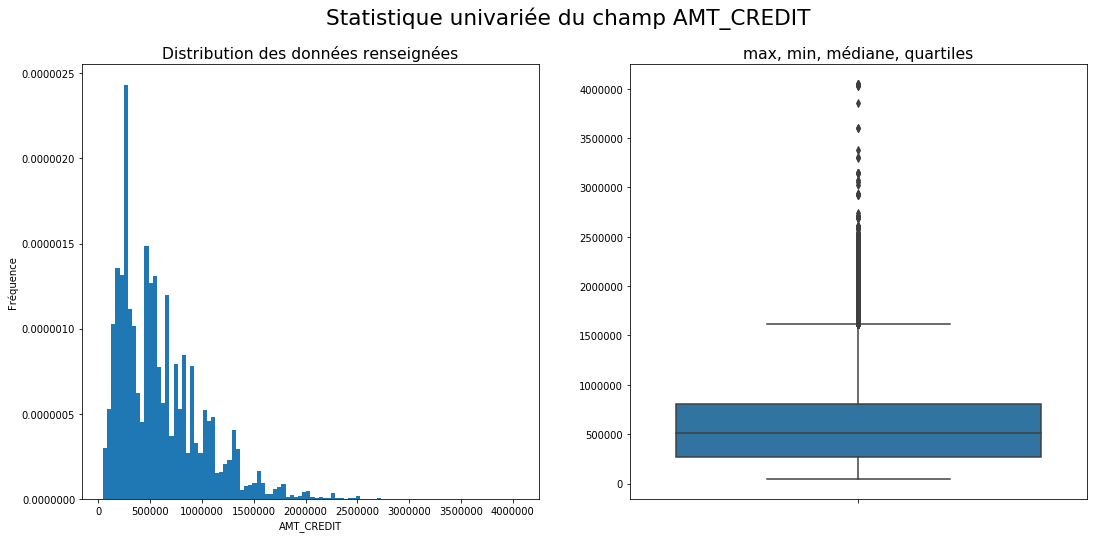

Mesures de position
 - Moyenne: 598734.88
 - Médiane: 513531.0
Mesures de dispertion
 - Ecart type: 402435.05
 - Min: 45000.0
 - Q25: 270000.0
 - Q75: 808650.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.24
 - Kurtosis (applatissement): 1.94

---------------------------------------------------------------------
YEARS_BEGINEXPLUATATION_MODE:3535


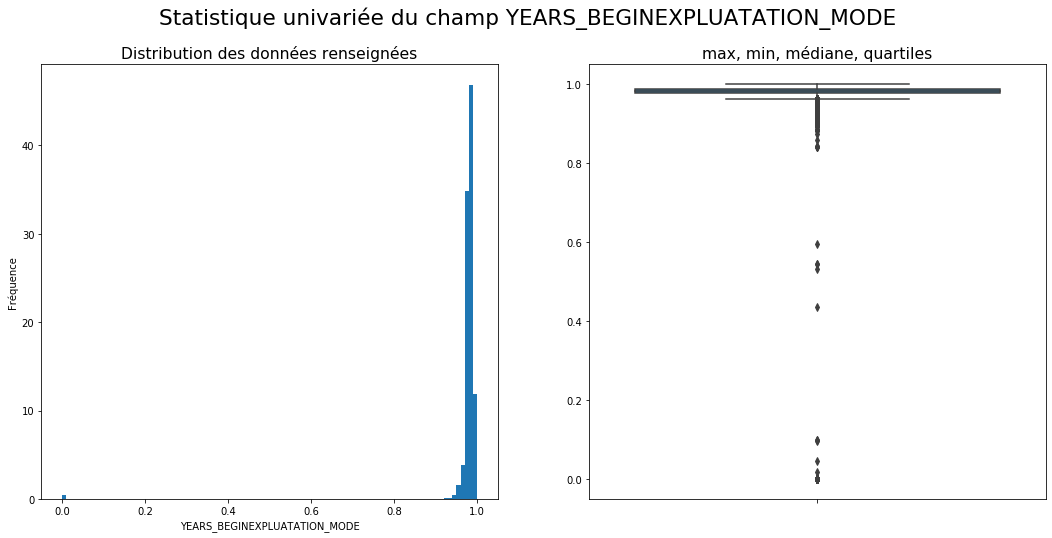

Mesures de position
 - Moyenne: 0.98
 - Médiane: 0.98
Mesures de dispertion
 - Ecart type: 0.06
 - Min: 0.0
 - Q25: 0.98
 - Q75: 0.99
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -14.96
 - Kurtosis (applatissement): 226.45


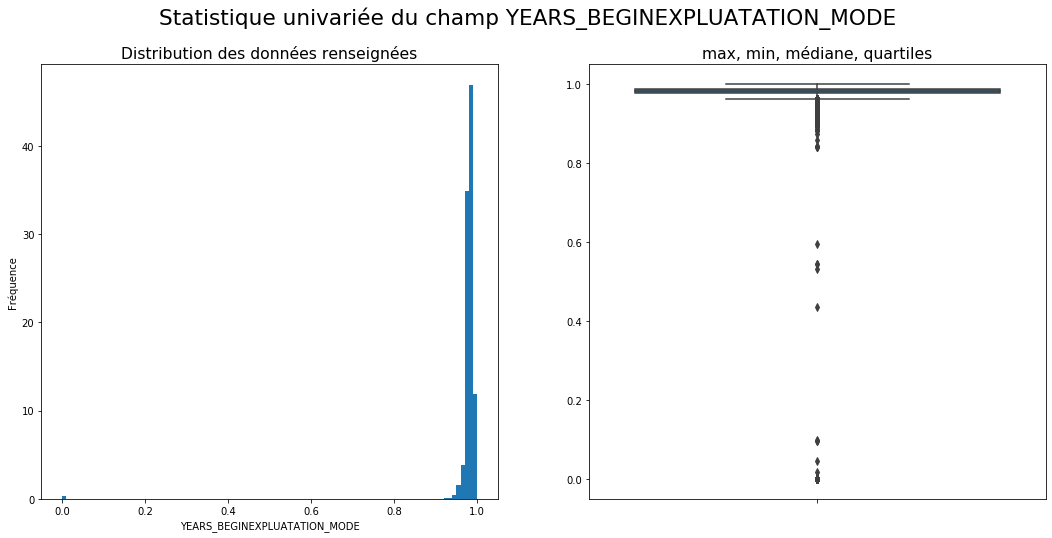

Mesures de position
 - Moyenne: 0.98
 - Médiane: 0.98
Mesures de dispertion
 - Ecart type: 0.06
 - Min: 0.0
 - Q25: 0.98
 - Q75: 0.99
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -16.63
 - Kurtosis (applatissement): 281.49

---------------------------------------------------------------------
PREV_DAYS_DECISION:2668


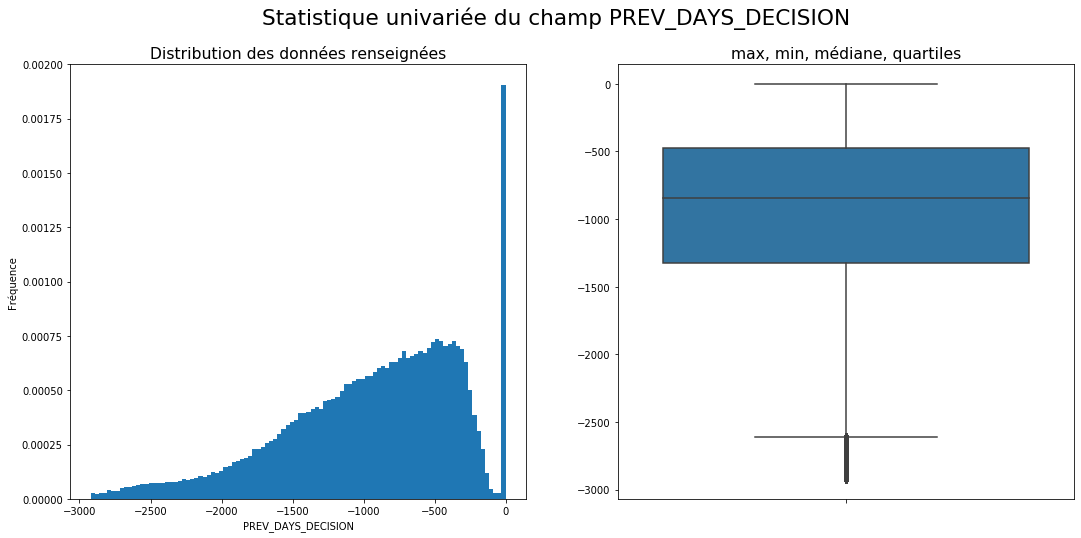

Mesures de position
 - Moyenne: -944.7
 - Médiane: -847.17
Mesures de dispertion
 - Ecart type: 615.29
 - Min: -2922.0
 - Q25: -1326.33
 - Q75: -472.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.71
 - Kurtosis (applatissement): 0.1


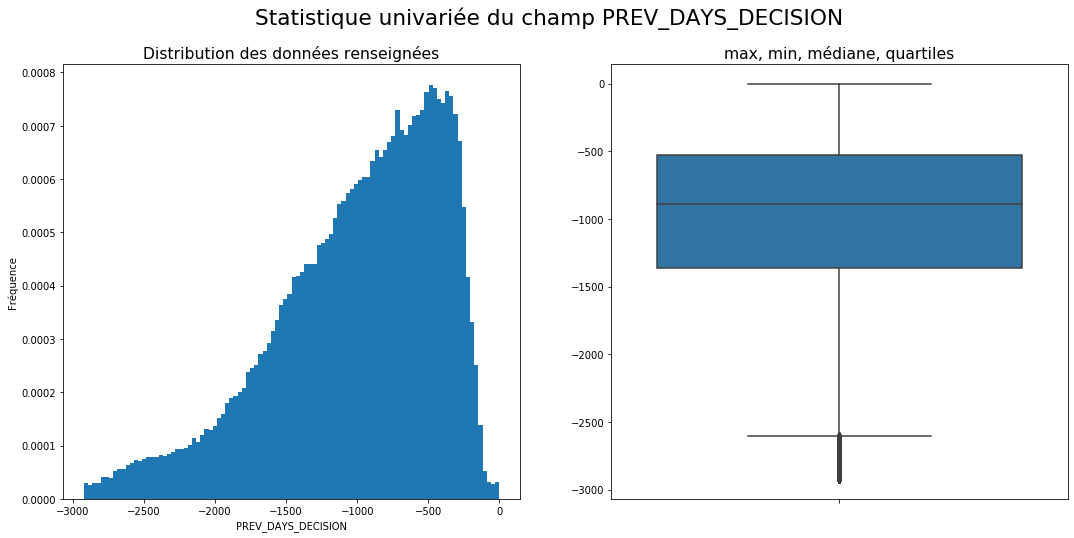

Mesures de position
 - Moyenne: -999.52
 - Médiane: -892.0
Mesures de dispertion
 - Ecart type: 588.01
 - Min: -2922.0
 - Q25: -1359.21
 - Q75: -528.33
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.82
 - Kurtosis (applatissement): 0.19

---------------------------------------------------------------------
BURO_DAYS_CREDIT:865


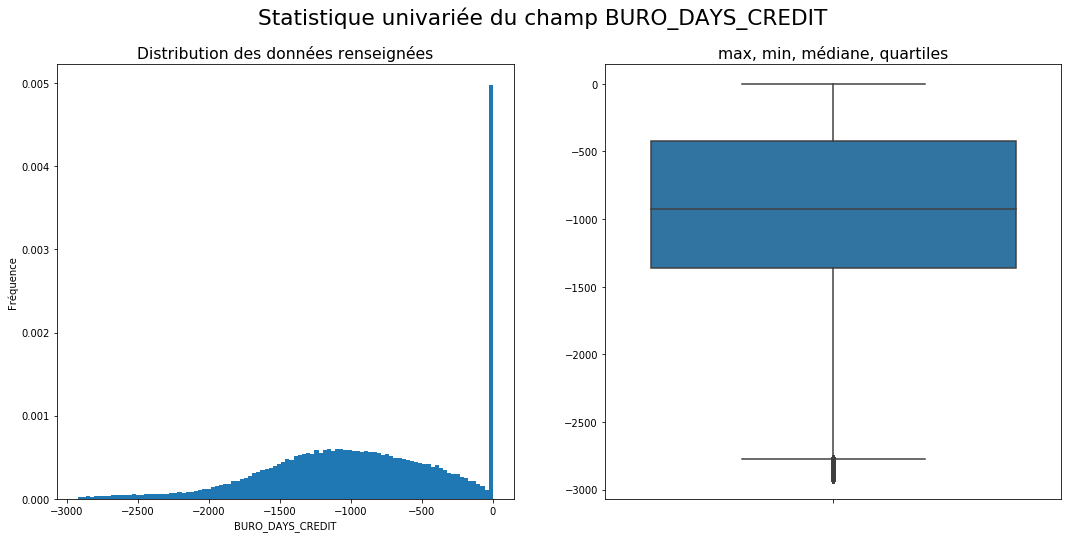

Mesures de position
 - Moyenne: -926.73
 - Médiane: -926.08
Mesures de dispertion
 - Ecart type: 644.67
 - Min: -2922.0
 - Q25: -1361.5
 - Q75: -422.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.35
 - Kurtosis (applatissement): -0.34


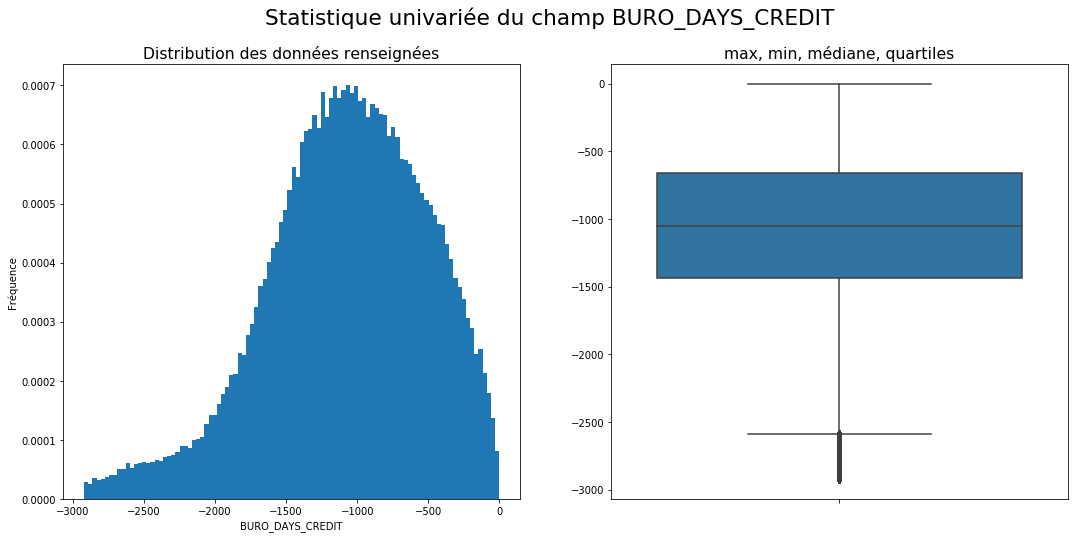

Mesures de position
 - Moyenne: -1082.2
 - Médiane: -1049.5
Mesures de dispertion
 - Ecart type: 563.1
 - Min: -2922.0
 - Q25: -1433.17
 - Q75: -663.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.5
 - Kurtosis (applatissement): 0.09

---------------------------------------------------------------------
NAME_EDUCATION_TYPE:116


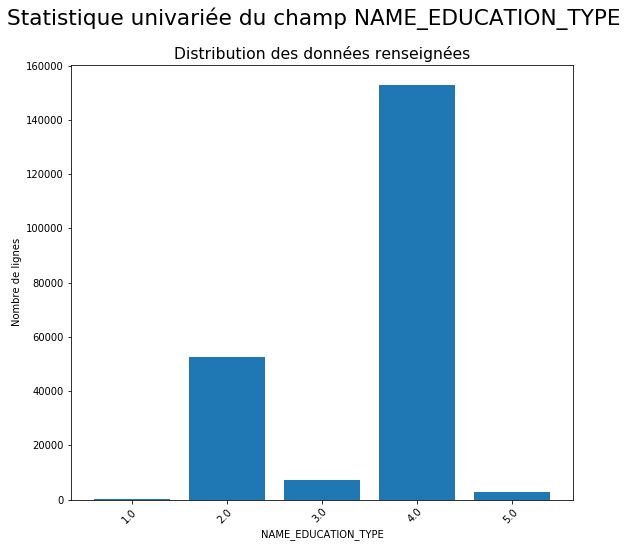

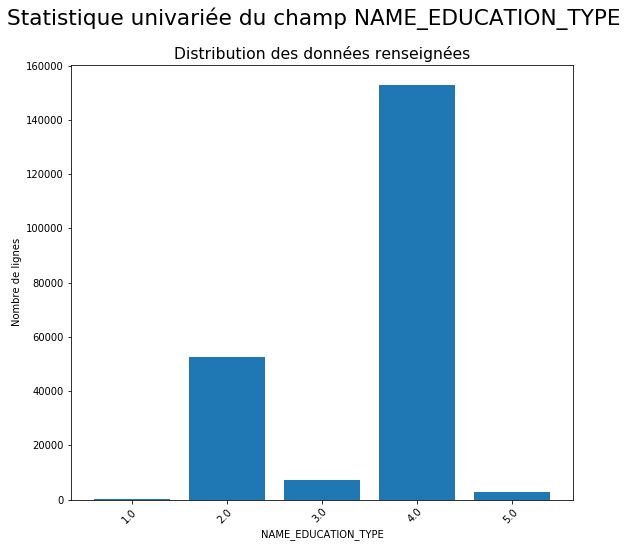


---------------------------------------------------------------------
PREV_NAME_YIELD_GROUP:0


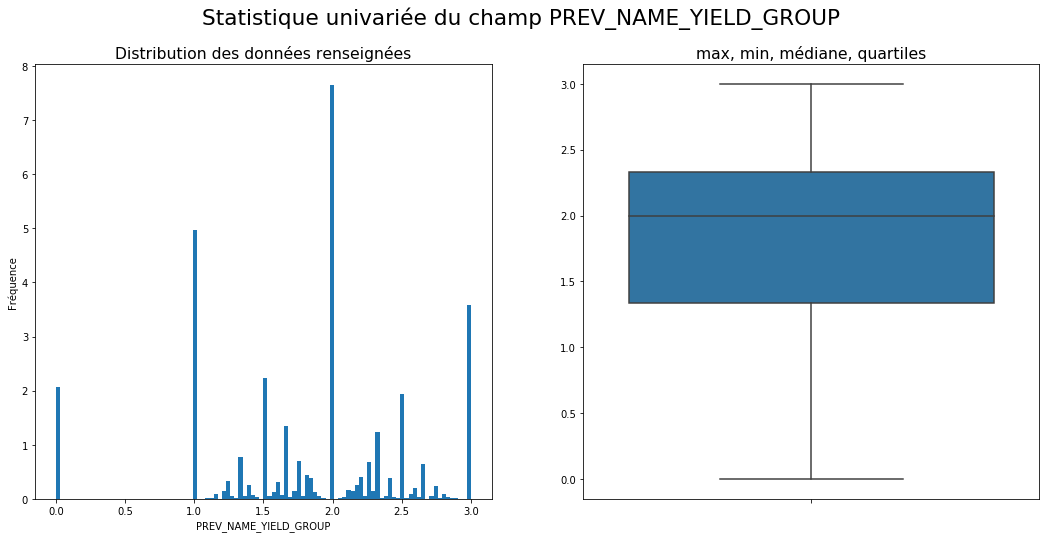

Mesures de position
 - Moyenne: 1.82
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 0.76
 - Min: 0.0
 - Q25: 1.33
 - Q75: 2.33
 - Max: 3.0
Mesures de forme
 - Skewness (asymétrie): -0.53
 - Kurtosis (applatissement): 0.09


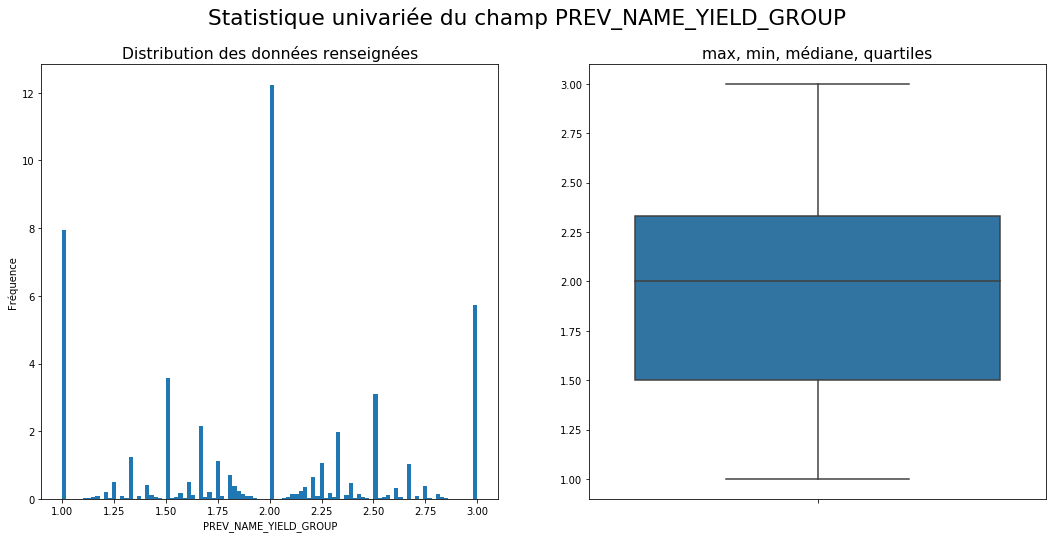

Mesures de position
 - Moyenne: 1.94
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 0.61
 - Min: 1.0
 - Q25: 1.5
 - Q75: 2.33
 - Max: 3.0
Mesures de forme
 - Skewness (asymétrie): 0.08
 - Kurtosis (applatissement): -0.82

---------------------------------------------------------------------
EXT_SOURCE_3:0


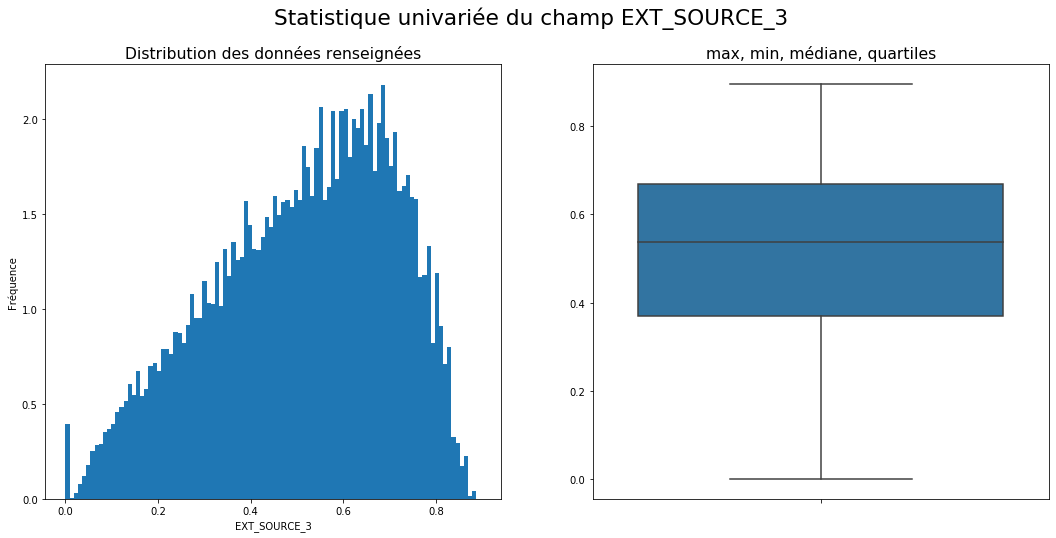

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.54
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.37
 - Q75: 0.67
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.66


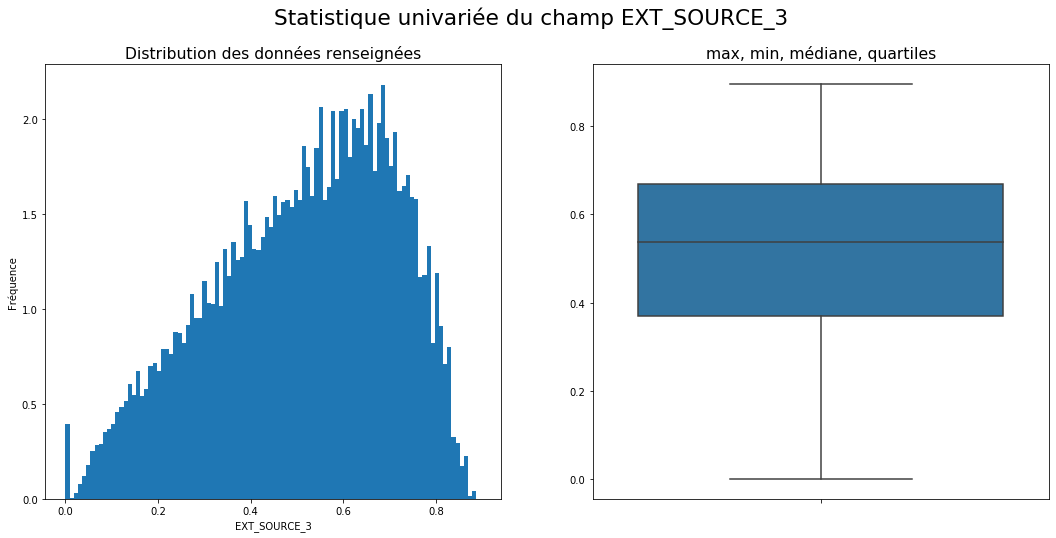

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.54
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.37
 - Q75: 0.67
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.66

---------------------------------------------------------------------
EXT_SOURCE_2:0


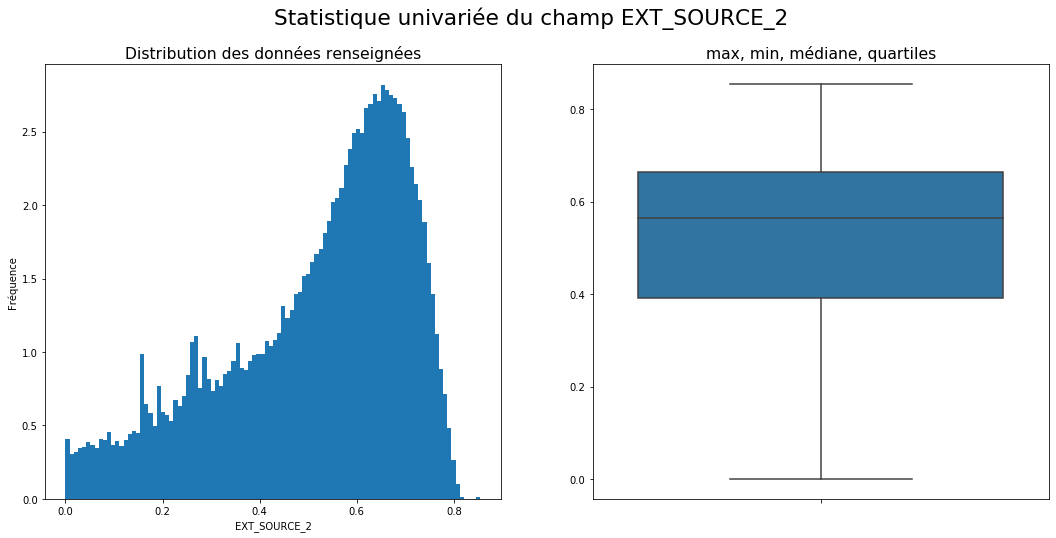

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.57
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.39
 - Q75: 0.66
 - Max: 0.85
Mesures de forme
 - Skewness (asymétrie): -0.79
 - Kurtosis (applatissement): -0.28


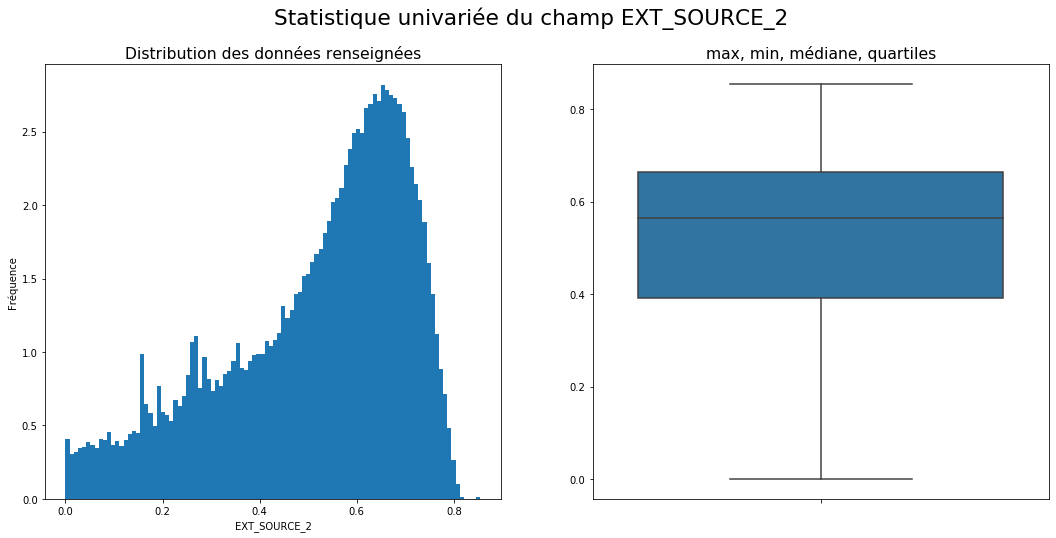

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.57
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.39
 - Q75: 0.66
 - Max: 0.85
Mesures de forme
 - Skewness (asymétrie): -0.79
 - Kurtosis (applatissement): -0.28


In [583]:
for index, row in statOutlierW.iterrows():
    print('')
    print('---------------------------------------------------------------------')
    print('{}:{}'.format(row.feature,row.nb_outliers))
    myDf(dfApplicationWorked).Stat(row.feature)
    myDf(dfApplicationWorked[dfApplicationWorked[row.feature] != 0]).Stat(row.feature)

<BarContainer object of 63 artists>

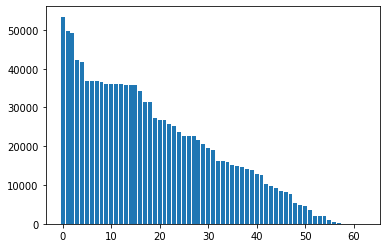

In [574]:
plt.bar([x for x in range(len(statOutlierD))], statOutlierD.nb_outliers.sort_values(ascending=False))

In [243]:
missingDefault = missingDefault.sort_values('impQ75Pond', ascending=False).reset_index(drop=True)
missingDefault

,feature,missRate,impMean,impMedian,impQ75,impMax,impQ75Pond
0,EXT_SOURCE_3,19.828856,0.126155,0.125784,0.127118,0.140768,0.114515
1,EXT_SOURCE_1,56.464598,0.079663,0.080515,0.081838,0.088282,0.058733
2,PREV_SELLERPLACE_AREA,0.000000,0.038310,0.037503,0.041620,0.052374,0.041620
3,EXT_SOURCE_2,0.213233,0.037243,0.037033,0.037674,0.042333,0.037634
4,DAYS_BIRTH,0.000000,0.027848,0.027360,0.030549,0.037259,0.030549
5,PREV_DAYS_FIRST_DUE,0.000000,0.025864,0.025868,0.028349,0.034876,0.028349
6,DAYS_EMPLOYED,0.000000,0.024144,0.024292,0.026956,0.032624,0.026956
7,BURO_DAYS_CREDIT,0.000000,0.022068,0.022151,0.026899,0.038149,0.026899
8,BURO_DAYS_CREDIT_UPDATE,0.000000,0.022359,0.022757,0.024321,0.031954,0.024321
9,PREV_HOUR_APPR_PROCESS_START,0.000000,0.022367,0.022349,0.023213,0.026976,0.023213


#### Suppression de colonnes peu importantes avec un fort taux de valeurs manquantes

In [244]:
def_miss_col_to_del = []
for index, row in missingDefault.iterrows():
    if (index >= 50) & (row.missRate >= 40):
        def_miss_col_to_del.append(row.feature)

In [245]:
len(dfApplicationDefault.columns)

205

In [246]:
missingDefault

,feature,missRate,impMean,impMedian,impQ75,impMax,impQ75Pond
0,EXT_SOURCE_3,19.828856,0.126155,0.125784,0.127118,0.140768,0.114515
1,EXT_SOURCE_1,56.464598,0.079663,0.080515,0.081838,0.088282,0.058733
2,PREV_SELLERPLACE_AREA,0.000000,0.038310,0.037503,0.041620,0.052374,0.041620
3,EXT_SOURCE_2,0.213233,0.037243,0.037033,0.037674,0.042333,0.037634
4,DAYS_BIRTH,0.000000,0.027848,0.027360,0.030549,0.037259,0.030549
5,PREV_DAYS_FIRST_DUE,0.000000,0.025864,0.025868,0.028349,0.034876,0.028349
6,DAYS_EMPLOYED,0.000000,0.024144,0.024292,0.026956,0.032624,0.026956
7,BURO_DAYS_CREDIT,0.000000,0.022068,0.022151,0.026899,0.038149,0.026899
8,BURO_DAYS_CREDIT_UPDATE,0.000000,0.022359,0.022757,0.024321,0.031954,0.024321
9,PREV_HOUR_APPR_PROCESS_START,0.000000,0.022367,0.022349,0.023213,0.026976,0.023213


In [247]:
for col in def_miss_col_to_del:
    del dfApplicationDefault[col]
    missingDefault = missingDefault[~missingDefault['feature'].isin([col])]
del dfApplicationDefault['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = missingDefault.reset_index(drop=True)

## Gestion des valeurs manquantes

### Aperçu des valeurs manquantes

#### Default data

In [ ]:
print(dfApplicationDefault.shape)
myDf(dfApplicationDefault).ColCountLinesChart(displayColName=False)

#### Transformed data

In [ ]:
print(dfApplicationWorked.shape)
myDf(dfApplicationWorked).ColCountLinesChart(displayColName=True)

In [107]:
dfApplicationWorked

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,BURO_CREDIT_ACTIVE,BURO_DAYS_CREDIT,BURO_DAYS_CREDIT_ENDDATE,BURO_AMT_CREDIT_MAX_OVERDUE,BURO_AMT_CREDIT_SUM_LIMIT,BURO_NB_CREDIT_TYPE,BURO_NB_BUREAU,BURO_MAIN_CREDIT_TYPE,BUROBAL_NB_BUREAU_BALANCE,BUROBAL_STATUS_BUREAU_DPD
210742,344213,0,1,0,0,0,2,152820.0,Working,4.0,...,0.333333,-1909.666667,-1347.666667,0.0,0.0,1.0,3.0,Credit card,0.0,0.0
290953,437056,0,1,0,0,0,1,755190.0,Working,2.0,...,0.500000,-642.500000,1183.500000,0.0,0.0,1.0,2.0,Consumer credit,0.0,0.0
120105,239275,0,1,0,0,1,0,125640.0,Working,4.0,...,0.333333,-1050.666667,571.333333,0.0,0.0,1.0,3.0,Credit card,0.0,0.0
162237,288090,0,1,1,0,0,0,491031.0,Commercial associate,4.0,...,0.000000,-475.500000,-110.500000,0.0,0.0,1.0,2.0,Consumer credit,0.0,0.0
257517,398001,0,1,0,0,1,0,505642.5,Pensioner,4.0,...,0.250000,-1525.500000,-749.857143,0.0,0.0,1.0,8.0,Consumer credit,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167914,294640,0,1,0,0,1,1,557770.5,Working,4.0,...,0.250000,-270.250000,367.500000,0.0,0.0,1.0,4.0,Consumer credit,0.0,0.0
99335,215328,0,1,0,0,0,0,360000.0,Working,4.0,...,0.428571,-1152.857143,-162.571429,0.0,0.0,1.0,7.0,Consumer credit,0.0,0.0
175582,303460,0,1,0,0,1,0,219042.0,Working,4.0,...,0.000000,-1141.000000,-861.000000,0.0,0.0,1.0,1.0,Consumer credit,0.0,0.0
148209,271846,0,1,0,1,1,0,254700.0,Pensioner,4.0,...,1.000000,-350.250000,803.750000,0.0,0.0,1.0,4.0,Consumer credit,0.0,0.0


In [62]:
for col in dfApplicationWorked

(215257, 62)

### Iterative imputer

In [29]:
import warnings
warnings.filterwarnings('ignore')

#### Optimisation de l'IterativeImputer sur le jeu de données travaillé

In [30]:
def evaluateImputer(imputer):
    from sklearn.impute import SimpleImputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    #t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', imputer), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    print( ' > %.3f (%.3f) %.0f ' % (mean(scores), std(scores), t2-t1))
    plt.boxplot([scores], labels=['mean imputer'], showmeans=True)
    plt.show()

In [34]:
dfApplicationWorkedImputer = dfApplicationWorked.copy()

categorical_ix = dfApplicationWorkedImputer.select_dtypes(include=['object']).columns
dfApplicationWorkedImputer[categorical_ix] = dfApplicationWorkedImputer[categorical_ix].replace(np.nan, 'missing')

dfApplicationWorkedImputer = dfApplicationWorkedImputer[0:50000]

del dfApplicationWorkedImputer['SK_ID_CURR']
y = dfApplicationWorkedImputer['TARGET']
del dfApplicationWorkedImputer['TARGET']
X = dfApplicationWorkedImputer

from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

Baseline: simple imputer

In [38]:
dfApplicationDefaultImputer = dfApplicationDefault.copy()

categorical_ix = dfApplicationDefaultImputer.select_dtypes(include=['object']).columns
dfApplicationDefaultImputer[categorical_ix] = dfApplicationDefaultImputer[categorical_ix].replace(np.nan, 'missing')

dfApplicationDefaultImputer = dfApplicationDefaultImputer[0:10000]

del dfApplicationDefaultImputer['SK_ID_CURR']
y = dfApplicationDefaultImputer['TARGET']
del dfApplicationDefaultImputer['TARGET']
X = dfApplicationDefaultImputer

from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

 > 0.728 (0.029) 99 


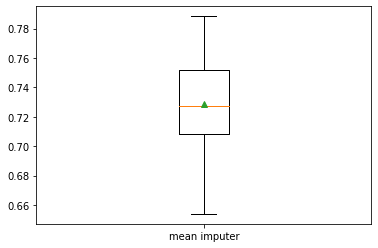

In [39]:
from sklearn.impute import SimpleImputer
evaluateImputer(SimpleImputer(strategy='mean'))

In [40]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)
pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=1))])

Xtrans = pipeline.fit_transform(X)

2021-01-16 11:03:49.523790


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


imputer = IterativeImputer()
strategies = ['1','2','5','10']
strategies = ['1']
encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

2021-01-16 08:25:34.414783
 >1 0.731 (0.031) 3027 


In [48]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=999))
strategies = ['1','2','5','10']
strategies = ['8']
encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=int(s)))), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

2021-01-16 12:36:52.281850


KeyboardInterrupt: 

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=999))
strategies = ['1','2','5','10']
strategies = ['8']
#encoder = OneHotEncoder(handle_unknown='ignore')
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=int(s)))), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

 > 0.734 (0.116) 14 


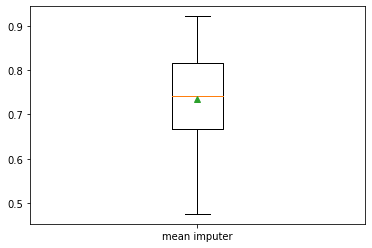

In [234]:
evaluateImputer(IterativeImputer(max_iter=10))

 > 0.722 (0.116) 13 


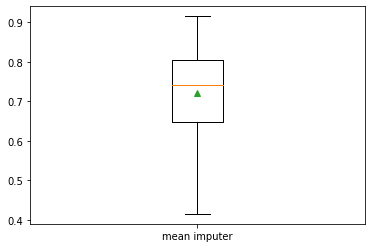

In [229]:
from sklearn.tree import DecisionTreeRegressor
evaluateImputer(IterativeImputer(max_iter=1, estimator=DecisionTreeRegressor()))

In [ ]:
results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    #t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', imputer), ('m', RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

IterativeImputer: optimisation de max_iter

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

results = list()
strategies = [str(i) for i in range(1, 10)]
for s in strategies:
    # create the modeling pipeline
    # n_jobs=None pour éviter TerminatedWorkerError
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

results = list()
strategies = {"min-max":MinMaxScaler(), "standard":StandardScaler(), "robust":RobustScaler()}
for label, scaler in strategies.items():
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    t = [('num', scaler, numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = Pipeline(steps=[('prep',col_transform), ( 'i' , IterativeImputer(max_iter=1)), ( 'm' , RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (label, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies.keys(), showmeans=True)
plt.show()

 >1 0.724 (0.025) 469 


WorkerInterrupt: 

IterativeImputer: optimisation de imputation_order

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

results = list()
strategies = ['ascending', 'descending', 'roman' ,'arabic' ,'random']
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    t = [('num', scaler, numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=1, imputation_order=s)), ('m', RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

NameError: name 'scaler' is not defined

IterativeImputer: optimisation du scaler

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

results = list()
strategies = {"min-max":MinMaxScaler(), "standard":StandardScaler(), "robust":RobustScaler()}
for label, scaler in strategies.items():
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    t = [('num', scaler, numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = Pipeline(steps=[('prep',col_transform), ( 'i' , IterativeImputer(max_iter=1)), ( 'm' , RandomForestRegressor(n_estimators=500, max_depth=6, n_jobs=-1))])
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (label, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies.keys(), showmeans=True)
plt.show()

 >min-max 0.725 (0.027) 140 


KeyboardInterrupt: 

#### Imputation des missing values

In [60]:
from sklearn.preprocessing import OrdinalEncoder

for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    categorical_ix = dfApplication.select_dtypes(include=['object']).columns
    dfApplication[categorical_ix] = dfApplication[categorical_ix].replace(np.nan, 'missing')

for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    for col in dfApplication.columns:
        if dfApplication[col].dtypes == 'object':
            ordinal_encoder = OrdinalEncoder()
            dfApplication[col] = ordinal_encoder.fit_transform(dfApplication[[col]])

Imputation sur le jeu de données travaillé

In [61]:
del dfApplicationDefaultImputer['SK_ID_CURR']
y = dfApplicationDefaultImputer['TARGET']
del dfApplicationDefaultImputer['TARGET']
X = dfApplicationDefaultImputer

In [ ]:
pipeline = Pipeline(steps=[('prep',col_transform), ( 'i' , IterativeImputer(max_iter=1)), ( 'm' , RandomForestRegressor(n_estimators=500, max_depth=6))])

In [201]:
dfApplicationDefaultSvg = dfApplicationDefault.copy()
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [235]:
for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    categorical_ix = dfApplication.select_dtypes(include=['object']).columns
    dfApplication[categorical_ix] = dfApplication[categorical_ix].replace(np.nan, 'missing')

for dfApplication in [dfApplicationDefault, dfApplicationWorked]:  
    for col in dfApplication.columns:
        if dfApplication[col].dtypes == 'object':
            ordinal_encoder = OrdinalEncoder()
            dfApplication[col] = ordinal_encoder.fit_transform(dfApplication[[col]])

In [236]:
imputer = IterativeImputer(max_iter=1)

dfApplicationDefault = dfApplicationDefault.reset_index(drop=True)
dfApplicationDefaultId = dfApplicationDefault['SK_ID_CURR']
dfApplicationDefaultTarget = dfApplicationDefault['TARGET']
del dfApplicationDefault['SK_ID_CURR']
y = dfApplicationDefault['TARGET'].values
del dfApplicationDefault['TARGET']
X = dfApplicationDefault.values

# fit on the dataset
imputer.fit(X)
# transform the dataset
X = imputer.transform(X)

/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [239]:
dfApplicationDefault = pd.concat([dfApplicationDefaultId,
                                   dfApplicationDefaultTarget,
                                   pd.DataFrame(X, columns = dfApplicationDefault.columns)], 
                                  axis=1)

In [240]:
imputer = IterativeImputer(max_iter=1)

dfApplicationWorked = dfApplicationWorked.reset_index(drop=True)
dfApplicationWorkedId = dfApplicationWorked['SK_ID_CURR']
dfApplicationWorkedTarget = dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']
y = dfApplicationWorked['TARGET'].values
del dfApplicationWorked['TARGET']
X = dfApplicationWorked.values

# fit on the dataset
imputer.fit(X)
# transform the dataset
X = imputer.transform(X)

In [241]:
dfApplicationWorked = pd.concat([dfApplicationWorkedId,
                                   dfApplicationWorkedTarget,
                                   pd.DataFrame(X, columns = dfApplicationWorked.columns)], 
                                  axis=1)

### One hot encoding des variables catégorielles

In [105]:
for dfApplication in [dfApplicationWorked, dfApplicationDefault]:  
    categorical_ix = dfApplication.select_dtypes(include=['object']).columns
    dfApplication[categorical_ix] = dfApplication[categorical_ix].replace(np.nan, 'missing')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

categorical_ix = dfApplicationDefault.select_dtypes(include=['object', 'bool']).columns
t = [('cat', OneHotEncoder(), categorical_ix)]
col_transform = ColumnTransformer(transformers=t)
pipeline = Pipeline(steps=[('prep',col_transform)])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

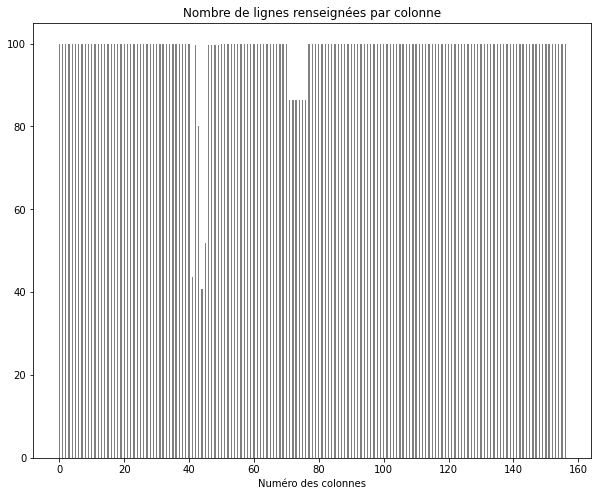

In [79]:
myDf(dfApplicationDefault).ColCountLinesChart(displayColName=False)

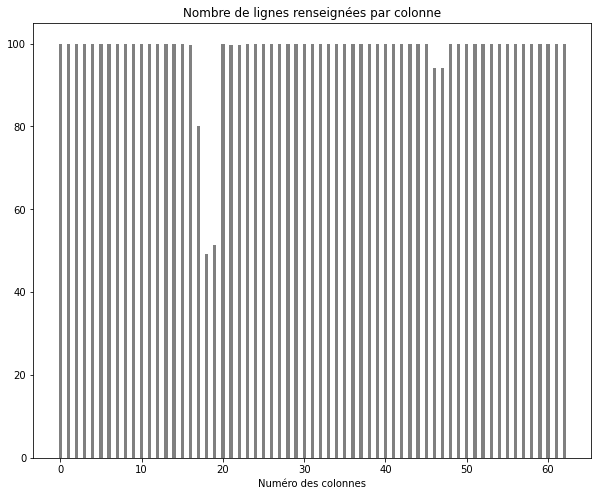

In [80]:
myDf(dfApplicationWorked).ColCountLinesChart(displayColName=False)

In [18]:
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline

def metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [], label_model = 'Modèle'):

    # training
    date1 = time.time()
    model.fit(X_train,y_train)
    date2 = time.time()
    duration_training = date2 - date1

    # predicting on train set
    date1 = time.time()
    #y_prob = model.predict_proba(X_train)[:,1] 
    y_prob = cross_val_predict(model, X_train, y_train, cv=3, method='predict_proba')[:,1] 
    date2 = time.time()
    duration_pred_train = date2 - date1

    # evaluating on train set
    date1 = time.time()
    fpr, tpr, thr = roc_curve(y_train, y_prob)
    roc_auc_train = auc(fpr, tpr)
    date2 = time.time()
    duration_metric_train = date2 - date1

    # predicting on test set
    date1 = time.time()
    #y_prob = model.predict_proba(X_test)[:,1] 
    y_prob = cross_val_predict(model, X_test, y_test, cv=3, method='predict_proba')[:,1] 
    date2 = time.time()
    duration_pred_test = date2 - date1

    # evaluating on test set
    date1 = time.time()
    fpr, tpr, thr = roc_curve(y_test, y_prob)
    roc_auc_test = auc(fpr, tpr)
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    date2 = time.time()
    duration_metric_test = date2 - date1

    if calc_feat_imp:
        feature_imp = pd.DataFrame(features,model.feature_importances_).reset_index(drop=False)
        feature_imp.columns = ["importance",'feature']
        feature_imp = feature_imp.sort_values("importance", ascending=False)
    else:
        feature_imp = ''
    
    if display_plot:
        
        import matplotlib.pyplot as plt
        import numpy as np
        
        size = 1
        if calc_feat_imp:
            nbPlot = 3
        else:
            nbPlot = 2
        fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))
        
        sub = fig.add_subplot(1,nbPlot,1)
        sub.set_title('Receiver Operating Characteristic')
        plt.plot(fpr,tpr, color='red',label = 'AUC = %0.2f' % roc_auc_test)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        sub = fig.add_subplot(1,nbPlot,2)
        sub.set_title('Precision-Recall curve')
        plt.plot(precision, recall,color='red')
        plt.legend(loc = 'lower right')
        plt.axis('tight')
        plt.ylabel('Recall')
        plt.xlabel('Precision')
        
        if calc_feat_imp:
            sub = fig.add_subplot(1,nbPlot,3)
            x = np.arange(len(features))
            #fig, ax = plt.subplots()
            #ax.yaxis.set_major_formatter(formatter)
            tmp = feature_imp.sort_values("importance", ascending=True)
            plt.barh(x, tmp.importance)
            plt.yticks(x, tmp.feature, rotation=0)
            sub.yaxis.tick_right()            
            plt.rcParams.update({'font.size':10, 'font.style':'normal'})
            sub.set_title('Feature importance')
        
        plt.rcParams.update({'font.size':12, 'font.style':'normal'})
        plt.suptitle(label_model)
        
        plt.show()
    
    return [duration_training, duration_pred_train, roc_auc_train, duration_pred_test, roc_auc_test, feature_imp]


In [19]:




def EvaluateModel(df, test_size=0.2, random_state=1):

    dfTrain, dfTest = train_test_split(df, test_size=test_size, random_state=random_state)
    
    X_train = dfTrain.copy()
    del X_train['TARGET']
    X_train = X_train.values
    y_train = dfTrain.TARGET.values
    
    X_test = dfTest.copy()
    del X_test['TARGET']
    X_test = X_test.values
    y_test = dfTest.TARGET.values
    

    # Knn avec pipeline et sélection du k
    list_train_dur = []
    list_train_scores = []
    list_train_pred_dur = []
    list_test_scores = []
    list_test_pred_dur = []
    strategies = [str(i) for i in [1,3,6,10,15,25,50]]
    for s in strategies:
        train_dur = []
        train_scores = []
        train_pred_dur = []
        test_scores = []
        test_pred_dur = []
        for _ in np.arange(10):
            pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
            duration_training, duration_pred_train, roc_auc_train, duration_pred_test, roc_auc_test, feature_imp = metrics_model(pipeline, X_train, y_train, X_test, y_test)
            train_dur.append(duration_training)
            train_scores.append(roc_auc_train)
            train_pred_dur.append(duration_pred_train)
            test_scores.append(roc_auc_test)
            test_pred_dur.append(duration_pred_test)
        list_train_dur.append(train_dur)
        list_train_scores.append(train_scores)
        list_train_pred_dur.append(train_pred_dur)
        list_test_scores.append(test_scores)
        list_test_pred_dur.append(test_pred_dur)
        print('>%s %.3f %.3f %.3f %.3f %.3f' % (s, mean(train_scores), mean(test_scores), mean(train_pred_dur), mean(test_pred_dur),  mean(train_dur)))
    pyplot.boxplot(list_train_scores, labels=strategies, showmeans=True)
    pyplot.boxplot(list_test_scores, labels=strategies, showmeans=True)
    pyplot.show()

>1 0.689 0.640 3.985 0.755 2.042
>3 0.691 0.643 4.084 0.762 2.100
>6 0.695 0.648 4.255 0.774 2.191
>10 0.694 0.645 4.263 0.776 2.189
>15 0.689 0.649 4.254 0.776 2.187
>25 0.691 0.644 4.262 0.772 2.163
>50 0.693 0.646 4.279 0.774 2.171


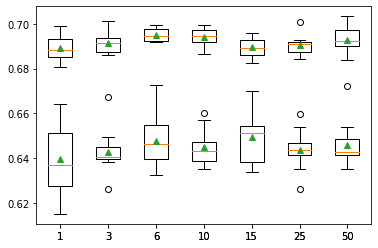

In [144]:
EvaluateModel(dfApplicationWorked)

>1 0.674 0.663 16.936 1.815 10.237
>3 0.680 0.678 18.280 1.975 10.771
>6 0.681 0.673 21.328 2.150 11.584
>10 0.682 0.672 19.521 1.997 10.368
>15 0.679 0.687 19.778 2.045 10.517
>25 0.679 0.683 19.683 2.049 10.377
>50 0.683 0.669 20.016 2.099 10.483


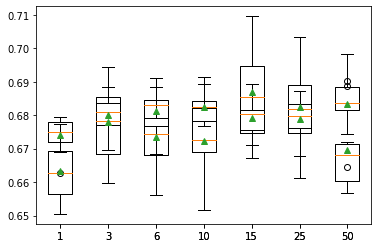

In [145]:
EvaluateModel(dfApplicationDefault)

### Gestion des valeurs manquantes

2021-01-02 18:57:15.006889    >    1 0.662 (0.035)
2021-01-02 18:57:34.409427    >    3 0.661 (0.039)
2021-01-02 18:57:54.068138    >    6 0.659 (0.045)
2021-01-02 18:58:13.875964    >    10 0.659 (0.042)
2021-01-02 18:58:33.832532    >    15 0.663 (0.048)
2021-01-02 18:58:53.667691    >    25 0.666 (0.049)
2021-01-02 18:59:13.465366    >    50 0.665 (0.048)


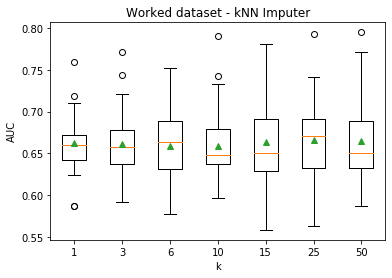

2021-01-02 19:01:00.648236    >    1 0.648 (0.042)
2021-01-02 19:02:50.323595    >    3 0.655 (0.045)
2021-01-02 19:04:42.553880    >    6 0.651 (0.044)
2021-01-02 19:06:34.653424    >    10 0.651 (0.039)
2021-01-02 19:08:28.393318    >    15 0.650 (0.041)
2021-01-02 19:10:21.964155    >    25 0.647 (0.041)
2021-01-02 19:12:16.181531    >    50 0.649 (0.039)


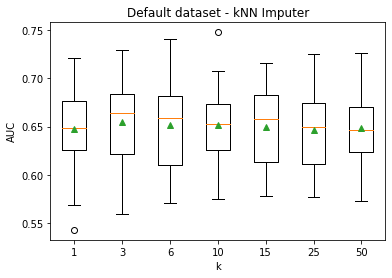

In [199]:
dfWorked, _ = train_test_split(dfApplicationWorked, test_size=0.95, random_state=1)
dfDefault = dfApplicationDefault.merge(dfWorked[['SK_ID_CURR']])
len(dfWorked)

for df in [dfWorked,dfDefault]:
    
    X = df.copy()
    y = df[['TARGET']]
    del X['TARGET']
    X = X.values
    y = y.values
    
    print('{}'.format(datetime.datetime.now()))

    # Comparer différentes stratégies d'imputation
    # evaluate each strategy on the dataset
    results = list()
    strategies = [str(i) for i in [1,3,6,10,15,25,50]]
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        # store results
        results.append(scores)
        print('{}    >    %s %.3f (%.3f)'.format(datetime.datetime.now()) % (s, mean(scores), std(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=strategies, showmeans=True)
    plt.ylabel('AUC')
    plt.xlabel('k')
    if len(df.columns) == len(dfApplicationWorked.columns):
        plt.title('Worked dataset - kNN Imputer')
    else:
        plt.title('Default dataset - kNN Imputer')
    plt.show()

In [200]:
len(dfWorked)

5273

10547
2021-01-02 19:13:35.583840
2021-01-02 19:14:49.846518    >    1 0.679 (0.030)
2021-01-02 19:16:04.052433    >    3 0.681 (0.030)
2021-01-02 19:17:19.774941    >    6 0.680 (0.033)
2021-01-02 19:18:34.330831    >    10 0.677 (0.037)
2021-01-02 19:19:49.405094    >    15 0.680 (0.035)
2021-01-02 19:21:04.032110    >    25 0.683 (0.033)
2021-01-02 19:22:18.752172    >    50 0.678 (0.034)


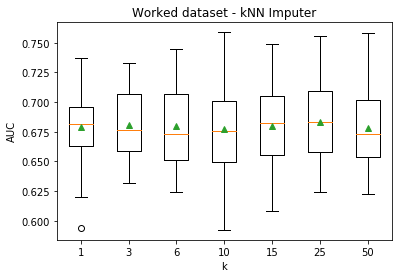

2021-01-02 19:22:18.916482


/home/pierre/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/pierre/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2021-01-02 19:29:30.578611    >    1 0.665 (0.024)
2021-01-02 19:36:52.336378    >    3 0.660 (0.027)
2021-01-02 19:44:22.767011    >    6 0.660 (0.033)
2021-01-02 19:51:54.133847    >    10 0.666 (0.029)
2021-01-02 19:59:24.469750    >    15 0.662 (0.025)
2021-01-02 20:06:56.890931    >    25 0.662 (0.026)
2021-01-02 20:14:27.064909    >    50 0.671 (0.027)


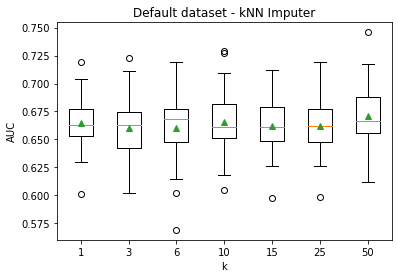

In [201]:
dfWorked, _ = train_test_split(dfApplicationWorked, test_size=0.9, random_state=1)
dfDefault = dfApplicationDefault.merge(dfWorked[['SK_ID_CURR']])
print(len(dfWorked))

for df in [dfWorked,dfDefault]:
    
    X = df.copy()
    y = df[['TARGET']]
    del X['TARGET']
    X = X.values
    y = y.values
    
    print('{}'.format(datetime.datetime.now()))

    # Comparer différentes stratégies d'imputation
    # evaluate each strategy on the dataset
    results = list()
    strategies = [str(i) for i in [1,3,6,10,15,25,50]]
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        # store results
        results.append(scores)
        print('{}    >    %s %.3f (%.3f)'.format(datetime.datetime.now()) % (s, mean(scores), std(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=strategies, showmeans=True)
    plt.ylabel('AUC')
    plt.xlabel('k')
    if len(df.columns) == len(dfApplicationWorked.columns):
        plt.title('Worked dataset - kNN Imputer')
    else:
        plt.title('Default dataset - kNN Imputer')
    plt.show()

In [255]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [254]:
import sklearn